# ACP Project - Model Evaluation

## Setup

In [1]:
import warnings, pickle, os
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 300)

from IPython.display import display
import matplotlib.pyplot as plt

import seaborn as sns

import shap
import optuna

%load_ext autoreload
%autoreload 1

In [2]:
from utils.evaluation import f2_score, METRICS, evaluate, evaluate_from_pred, with_sampling_strategies, spotCheckCV, spotCheckDatasets, F2TabNet, joint_plot
from utils.isolation_forest_wrapper import IsolationForestWrapper
%aimport utils.evaluation

In [3]:
from hyperparameter_tuning import tune_xgboost, tune_tabnet, tune_lgbm, tune_randomforest, tune_isolationforest, tune_logisticregression
%aimport hyperparameter_tuning

In [4]:
class Notebook:
    IMAGE_DIR = "images/critical_event_24_missing_values"
    MODEL_DIR = "models/critical_event_24_missing_values"
    OUTCOME = "CriticalEvent"
    OUTCOME_WITHIN = 1

    SAVE_MODELS = True
    SAVE_IMAGES = True

    RUN_HYPERPARAMETERS = True
    HYPERPARAMETER_TIMEOUT = 60 * 60 * 2
    HYPERPARAMETER_NJOBS = 4

    SHAP_PLOTS_MAXDISPLAY = 20
    EVAL_N_RESAMPLES = 9999

    MODELS = {}
    EXPLAINERS = {}
    EVAL_RESULTS = {}
    TUNED_RESULTS = {}
    MORTALITY_RESULTS = {}
    CRITICALCARE_RESULTS = {}


In [5]:
try:
    os.makedirs(Notebook.IMAGE_DIR)
    os.makedirs(Notebook.MODEL_DIR)
except FileExistsError:
    pass


In [6]:
def restore():
    with open(f"{Notebook.MODEL_DIR}/models.bin", "rb") as file:
        Notebook.MODELS = pickle.load(file)

    with open(f"{Notebook.MODEL_DIR}/explainers.bin", "rb") as file:
        Notebook.EXPLAINERS = pickle.load(file)


### Dataset

In [7]:
from dataset import SCIData, SCICols
from utils.data_profiling import ensure_categorical_overlap, drop_exclusive_cols
%aimport dataset, utils.data_profiling

sci = (
    SCIData.load('data/sci_processed.h5')
    .fix_readmissionband()
    .derive_critical_event(within=Notebook.OUTCOME_WITHIN, return_subcols=True)
)
Notebook.OUTCOME = 'CriticalEvent'


In [8]:
from sklearn.model_selection import train_test_split

scii = (
    SCIData(sci.sort_values("AdmissionDateTime"))
    .omit_redundant()
    .drop(["ReadmissionBand", "AgeBand", "LastSpecialty"], axis=1)
    .omit_ae()
    .raw_news()
    .mandate_news()
    .augment_hsmr()
)

sci_train, sci_test = train_test_split(
    scii, test_size=0.33, random_state=42, shuffle=False
)
y_test_mortality, y_test_criticalcare = (
    sci_test.DiedWithinThreshold.copy(),
    sci_test.CriticalCare.copy(),
)

if Notebook.OUTCOME == "CriticalEvent":
    sci_train, sci_test = (
        sci_train.drop(
            ["DiedWithinThreshold", "CriticalCare"], axis=1, errors="ignore"
        ),
        sci_test.drop(["DiedWithinThreshold", "CriticalCare"], axis=1, errors="ignore"),
    )

sci_train, sci_test = SCIData(sci_train), SCIData(sci_test)

# Drop HSMR_15 as there is only 1 in the entire dataset, making a split impossible
(X_train, y_train), (X_test, y_test) = (
    sci_train.impute_blood()
    .encode_ccs_onehot()
    .xy(outcome=Notebook.OUTCOME, ordinal_encoding=True, dropna=False, fillna=True),
    sci_test.impute_blood()
    .encode_ccs_onehot()
    .xy(outcome=Notebook.OUTCOME, ordinal_encoding=True, dropna=False, fillna=True),
)
categorical_cols_idx, categorical_cols_dims = X_train.describe_categories()
drop_exclusive_cols(X_train, X_test)
ensure_categorical_overlap(X_train, X_test, categorical_cols_idx)

# Mandated vitals, Categorical diagnoses (main only)
(X_train_if, y_train_if), (X_test_if, y_test_if) = (
    sci_train.drop(SCICols.diagnoses[1:], axis=1).xy(
        outcome=Notebook.OUTCOME, ordinal_encoding=True, fillna=True
    ),
    sci_test.drop(SCICols.diagnoses[1:], axis=1).xy(
        outcome=Notebook.OUTCOME, ordinal_encoding=True, fillna=True
    ),
)
drop_exclusive_cols(X_train_if, X_test_if)

(X_train_lgbm, y_train_lgbm), (X_test_lgbm, y_test_lgbm) = (
    sci_train.encode_ccs_onehot().xy(
        outcome=Notebook.OUTCOME, ordinal_encoding=True, fillna=False
    ),
    sci_test.encode_ccs_onehot().xy(
        outcome=Notebook.OUTCOME, ordinal_encoding=True, fillna=False
    ),
)
drop_exclusive_cols(X_train_lgbm, X_test_lgbm)
ensure_categorical_overlap(X_train_lgbm, X_test_lgbm, categorical_cols_idx)

(X_train_tn, X_valid_tn, y_train_tn, y_valid_tn) = train_test_split(
    X_train.to_numpy(),
    y_train.to_numpy(),
    stratify=y_train,
    test_size=0.33,
    random_state=42,
)

(X_train_news, y_train_news), (X_test_news, y_test_news) = (
    sci_train.xy(
        outcome=Notebook.OUTCOME, x=SCICols.news_data_raw, dtype=float, fillna=True
    ),
    sci_test.xy(
        outcome=Notebook.OUTCOME, x=SCICols.news_data_raw, dtype=float, fillna=True
    ),
)
drop_exclusive_cols(X_train_news, X_test_news)


### Tuning

In [9]:
from sklearn.metrics import precision_recall_curve


def get_threshold(y_train, y_pred_proba, target=0.85):
    """ Given prediction probabilities, sets the prediction threshold to approach the given target recall
    """

    # Get candidate thresholds from the model, and find the one that gives the best fbeta score
    precision, recall, thresholds = precision_recall_curve(y_train, y_pred_proba)
    closest = thresholds[np.abs(recall - target).argmin()]

    return closest


## Models

### Baseline (NEWS)

Accuracy  Precision   Recall  F1 Score  F2 Score      AUC       AUC_CI
Model  0.979539   0.129032  0.35023  0.188586   0.26081  0.83729  0.805-0.868

array([[31234,   513],
       [  141,    76]])

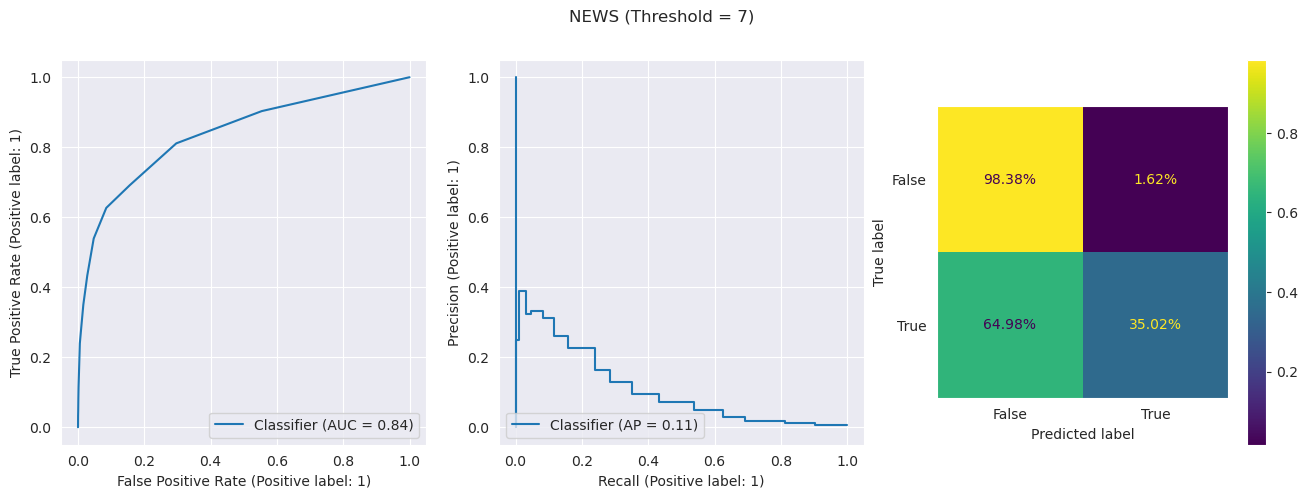

In [10]:
baseline_mask = sci[sci.c_NEWS_score.notna()].index.intersection(sci_test.index)
Notebook.EVAL_RESULTS["Baseline (NEWS)"] = evaluate_from_pred(
    y_test.loc[baseline_mask],
    y_pred=(sci.loc[baseline_mask].c_NEWS_score >= 7),
    y_pred_proba=(sci.loc[baseline_mask].c_NEWS_score),
    plot_title="NEWS (Threshold = 7)",
    save=f"{Notebook.IMAGE_DIR}/baseline_news.png" if Notebook.SAVE_IMAGES else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


Mortality


Accuracy  Precision  Recall  F1 Score  F2 Score       AUC       AUC_CI
Model  0.982699   0.106961     0.7  0.185567  0.331928  0.952171  0.926-0.973

array([[31348,   526],
       [   27,    63]])

Critical Care


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.978538   0.033956  0.145985  0.055096  0.087951  0.771084   

            AUC_CI  
Model  0.726-0.814

array([[31258,   569],
       [  117,    20]])

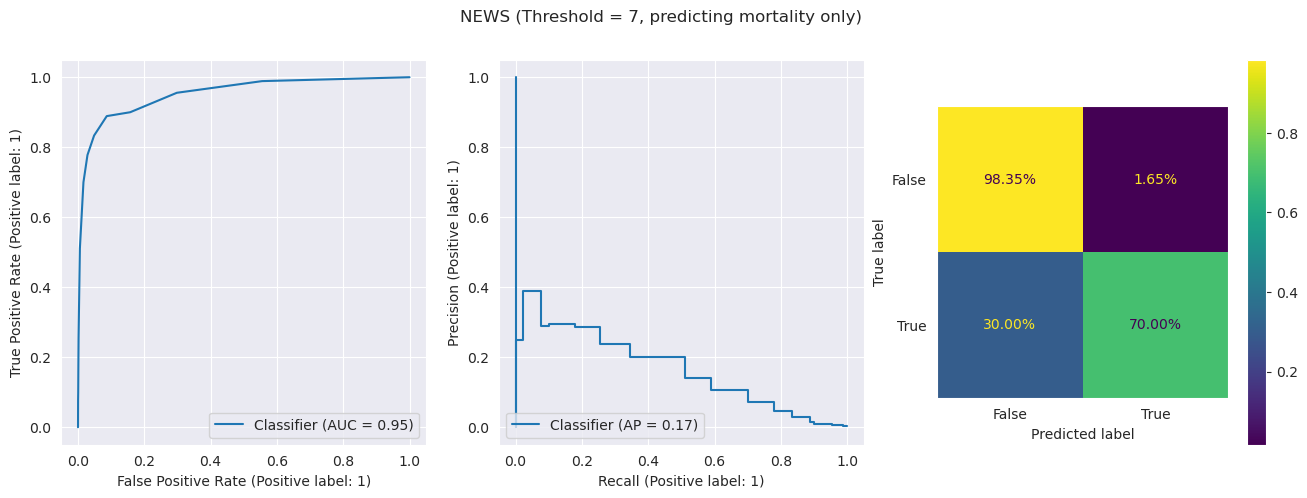

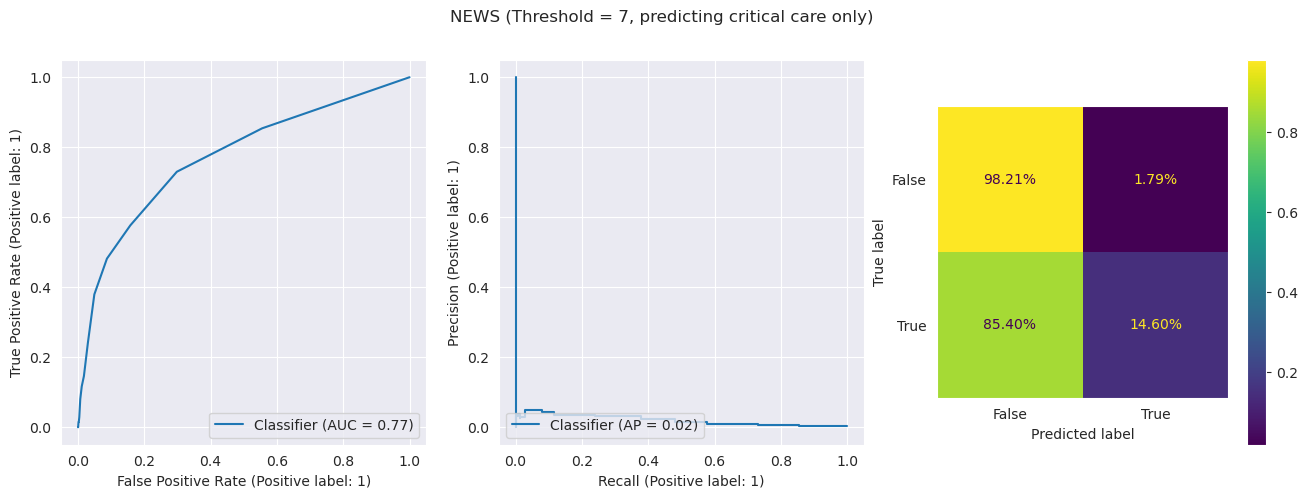

In [11]:
print("Mortality")
Notebook.MORTALITY_RESULTS["Baseline (NEWS)"] = evaluate_from_pred(
    y_test_mortality.loc[baseline_mask],
    y_pred=(sci.loc[baseline_mask].c_NEWS_score >= 7),
    y_pred_proba=(sci.loc[baseline_mask].c_NEWS_score),
    plot_title="NEWS (Threshold = 7, predicting mortality only)",
    save=f"{Notebook.IMAGE_DIR}/baseline_news_mortality.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)

print("Critical Care")
Notebook.CRITICALCARE_RESULTS["Baseline (NEWS)"] = evaluate_from_pred(
    y_test_criticalcare.loc[baseline_mask],
    y_pred=(sci.loc[baseline_mask].c_NEWS_score >= 7),
    y_pred_proba=(sci.loc[baseline_mask].c_NEWS_score),
    plot_title="NEWS (Threshold = 7, predicting critical care only)",
    save=f"{Notebook.IMAGE_DIR}/baseline_news_criticalcare.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)



### Logistic Regression (NEWS only)

Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.866162   0.034182  0.686636  0.065122  0.142529  0.837522   

            AUC_CI  
Model  0.804-0.869

array([[27537,  4210],
       [   68,   149]])

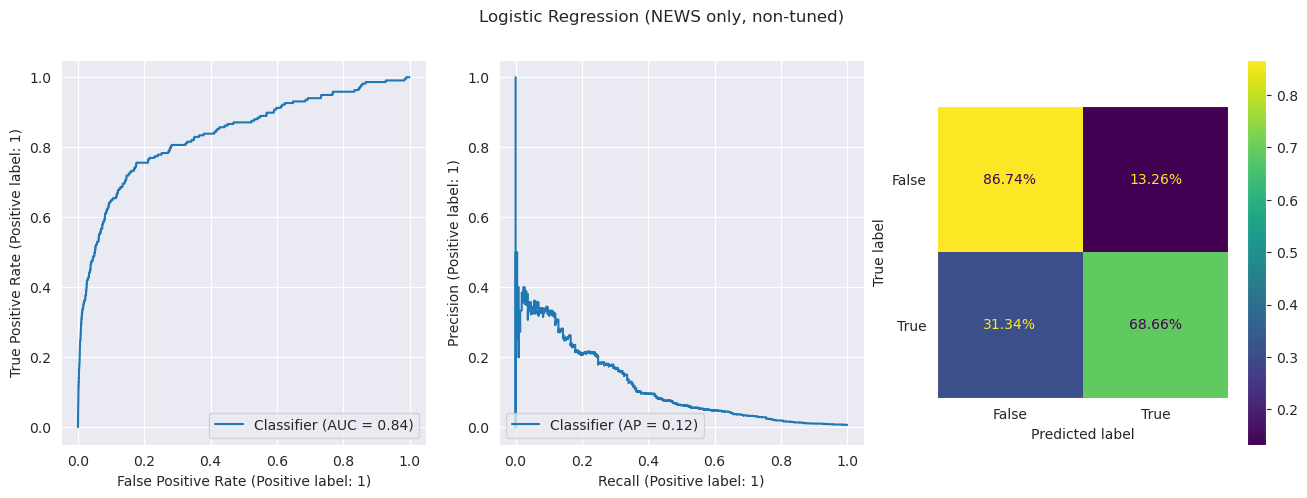

In [12]:
from sklearn.linear_model import LogisticRegression

modelkey = "Logistic Regression (NEWS only)"
model = LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42).fit(
    X_train_news, y_train_news
)
Notebook.MODELS[modelkey] = model

Notebook.EVAL_RESULTS[modelkey] = evaluate(
    model,
    X_test_news,
    y_test_news,
    plot_title="Logistic Regression (NEWS only, non-tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_logistic_news.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.534382   0.012498  0.866359  0.024641  0.059082  0.837522   

            AUC_CI  
Model  0.804-0.869

array([[16893, 14854],
       [   29,   188]])

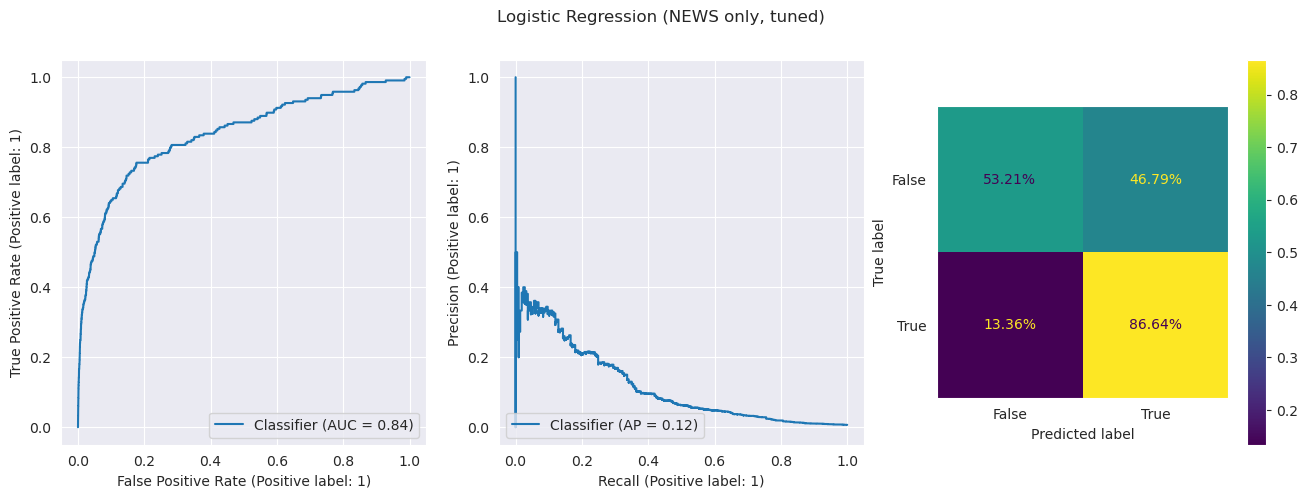

In [13]:
threshold = get_threshold(y_train_news, model.predict_proba(X_train_news)[:, 1],)

y_pred_proba = model.predict_proba(X_test_news)[:, 1]
y_pred = np.where(y_pred_proba > threshold, 1, 0)

Notebook.TUNED_RESULTS[modelkey] = evaluate_from_pred(
    y_test_news,
    y_pred,
    y_pred_proba,
    plot_title="Logistic Regression (NEWS only, tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_thresholded_logistic_news.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)



Mortality


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.532036   0.005784  0.966667  0.011499  0.028243  0.931502   

            AUC_CI  
Model  0.893-0.964

array([[16919, 14955],
       [    3,    87]])

Critical Care


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.532067   0.007379  0.810219  0.014625    0.0356  0.784876   

            AUC_CI  
Model  0.741-0.826

array([[16896, 14931],
       [   26,   111]])

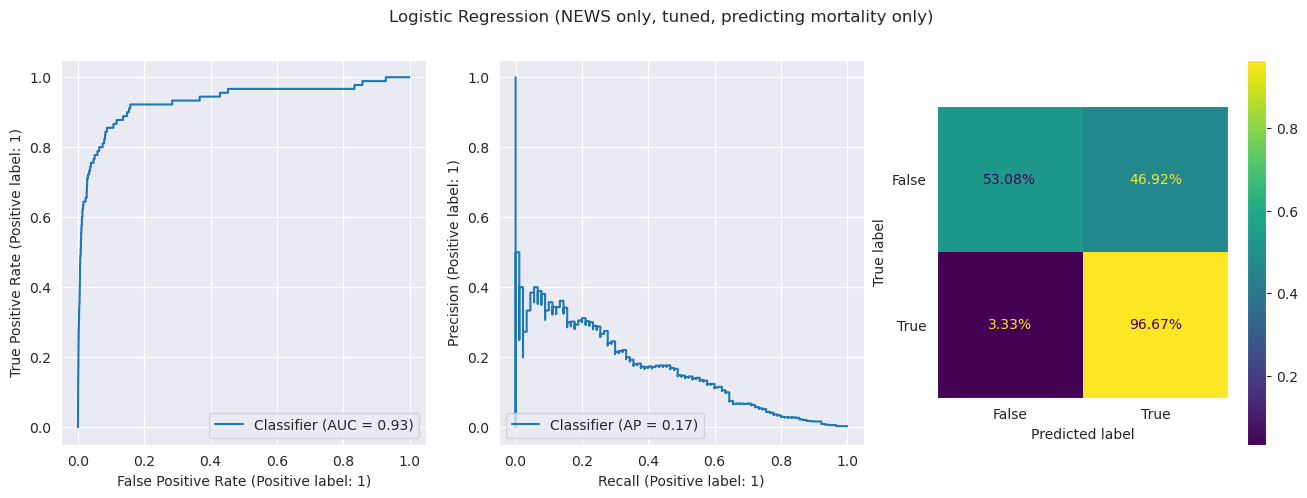

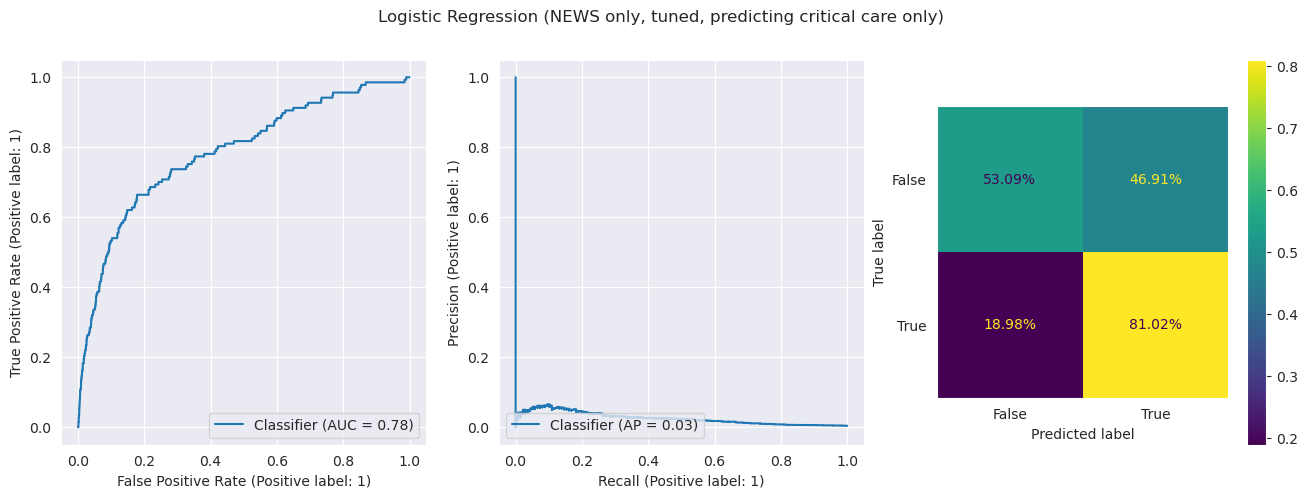

In [14]:
print("Mortality")
Notebook.MORTALITY_RESULTS[modelkey] = evaluate_from_pred(
    y_test_mortality,
    y_pred,
    y_pred_proba,
    plot_title="Logistic Regression (NEWS only, tuned, predicting mortality only)",
    save=f"{Notebook.IMAGE_DIR}/eval_mortality_thresholded_logistic_news.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)

print("Critical Care")
Notebook.CRITICALCARE_RESULTS[modelkey] = evaluate_from_pred(
    y_test_criticalcare,
    y_pred,
    y_pred_proba,
    plot_title="Logistic Regression (NEWS only, tuned, predicting critical care only)",
    save=f"{Notebook.IMAGE_DIR}/eval_criticalcare_thresholded_logistic_news.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

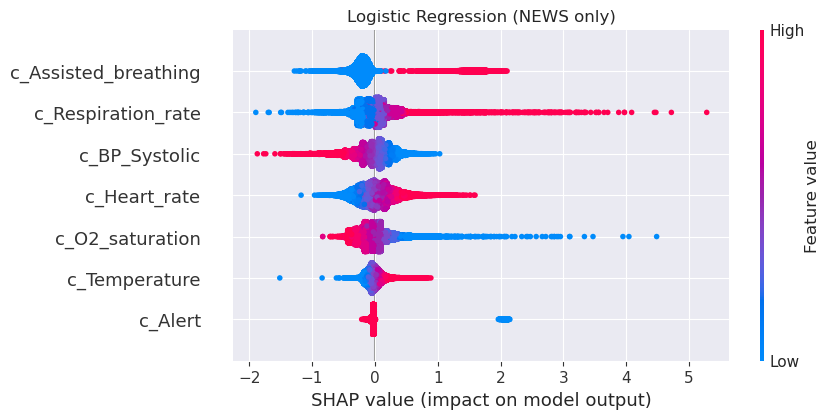

In [15]:
explainer = shap.LinearExplainer(
    model, X_train_news, feature_perturbation="correlation_dependent"
)
shap_values = explainer(X_test_news)
Notebook.EXPLAINERS[modelkey] = (explainer, shap_values)

fig = shap.plots.beeswarm(
    shap_values, max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("Logistic Regression (NEWS only)")

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/shap_swarm_logistic_regression_news.png",
        bbox_inches="tight",
    )


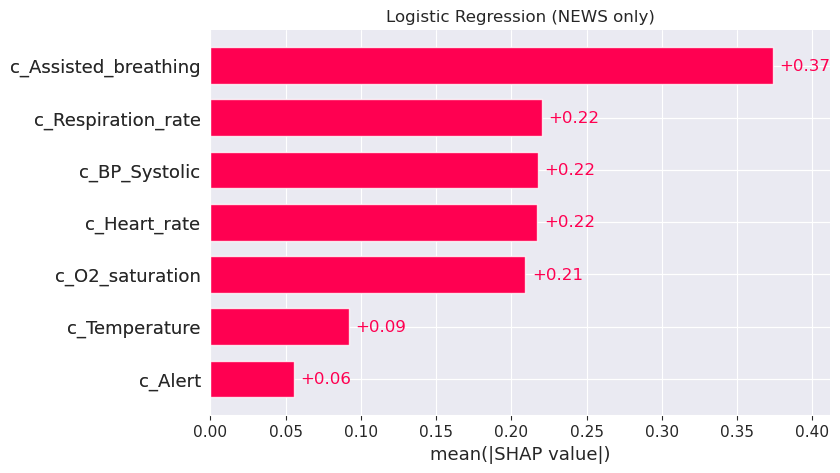

In [16]:
fig = shap.plots.bar(
    shap_values, max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("Logistic Regression (NEWS only)")

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/shap_bar_logistic_regression_news.png",
        bbox_inches="tight",
    )


### Logistic Regression

In [17]:
lr_params = {
    "LR__max_iter": 10000,
    "LR__penalty": "l2",
    "LR__solver": "lbfgs",
    "LR__C": 7.87,
    "LR__class_weight": "balanced",
    "IMB__sampling_strategy": 0.2,
}

if Notebook.RUN_HYPERPARAMETERS:
    lr_params.update(
        tune_logisticregression(
            X_train,
            y_train,
            timeout=Notebook.HYPERPARAMETER_TIMEOUT,
            n_jobs=Notebook.HYPERPARAMETER_NJOBS,
        )
    )


BEST PARAMETERS
{'LR__penalty': 'l2', 'LR__C': 8.328583693217313, 'LR__class_weight': None, 'IMB__sampling_strategy': 0.26141714312248365}


X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.963021   0.109943  0.626728   0.18707   0.32304  0.915763   

            AUC_CI  
Model  0.891-0.938

array([[30646,  1101],
       [   81,   136]])

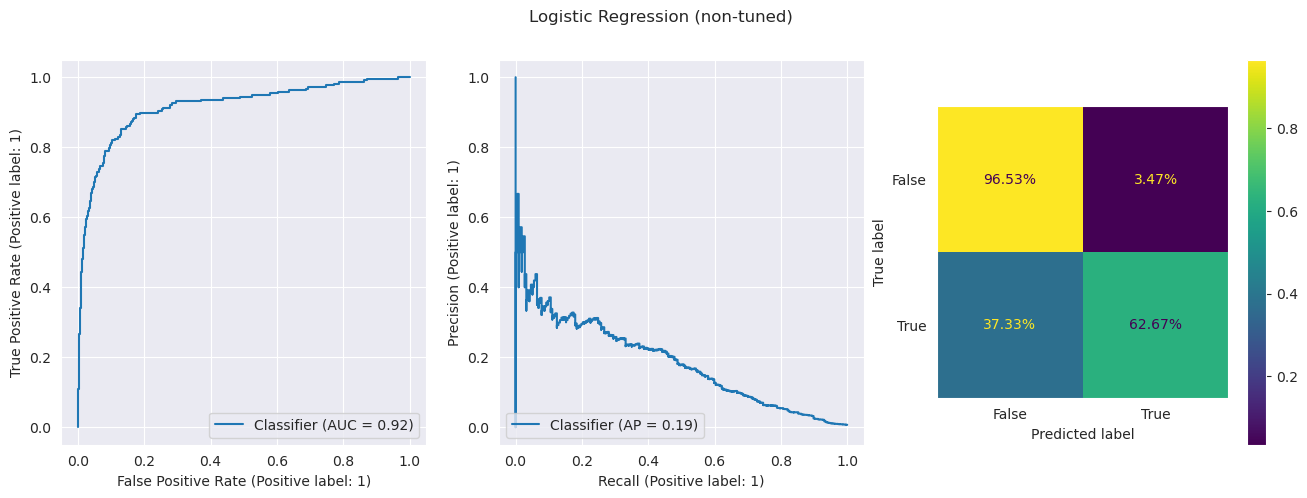

In [18]:
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler

modelkey = "Logistic Regression"
model = (
    ImbPipeline(steps=[("IMB", RandomUnderSampler()), ("LR", LogisticRegression()),])
    .set_params(**lr_params)
    .fit(X_train, y_train)
)

Notebook.EVAL_RESULTS[modelkey] = evaluate(
    model,
    X_test,
    y_test,
    plot_title="Logistic Regression (non-tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_logistic_regression.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)

Notebook.MODELS[modelkey] = model


X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.863753   0.041038  0.852535  0.078307  0.172061  0.915763   

            AUC_CI  
Model  0.891-0.938

array([[27424,  4323],
       [   32,   185]])

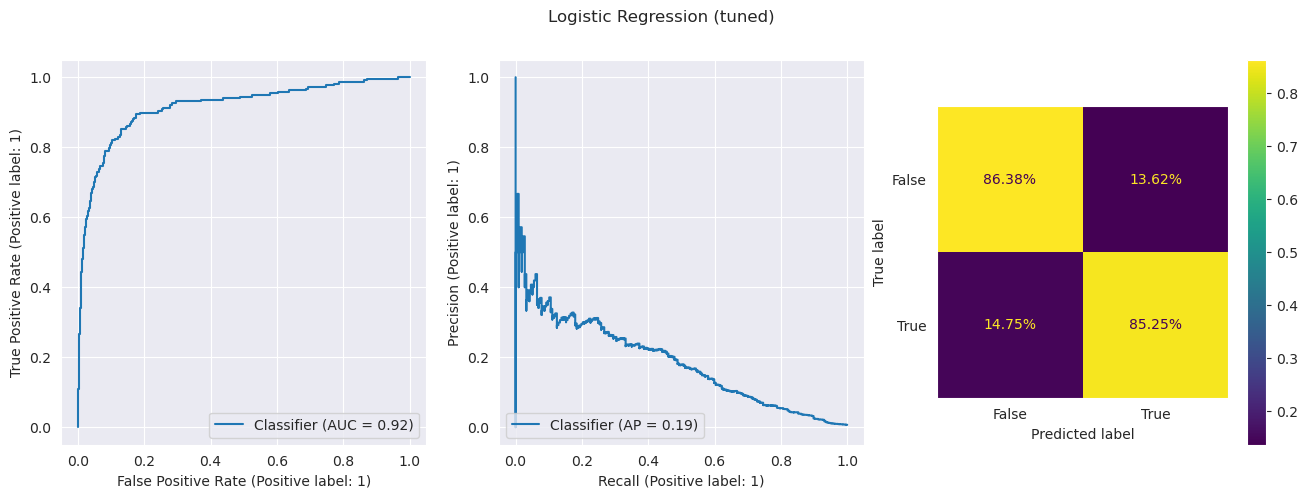

In [19]:
threshold = get_threshold(y_train, model.predict_proba(X_train)[:, 1],)

# Create predictions on the test set, using this new threshold
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = np.where(y_pred_proba > threshold, 1, 0)

# Produce scores
Notebook.TUNED_RESULTS[modelkey] = evaluate_from_pred(
    y_test,
    y_pred,
    y_pred_proba,
    plot_title="Logistic Regression (tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_thresholded_logistic_regression.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


Mortality


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.861094   0.017524  0.877778  0.034363  0.081142  0.934184   

            AUC_CI  
Model  0.904-0.960

array([[27445,  4429],
       [   11,    79]])

Critical Care


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.861938   0.025732  0.846715  0.049946  0.114715  0.907051   

            AUC_CI  
Model  0.872-0.937

array([[27435,  4392],
       [   21,   116]])

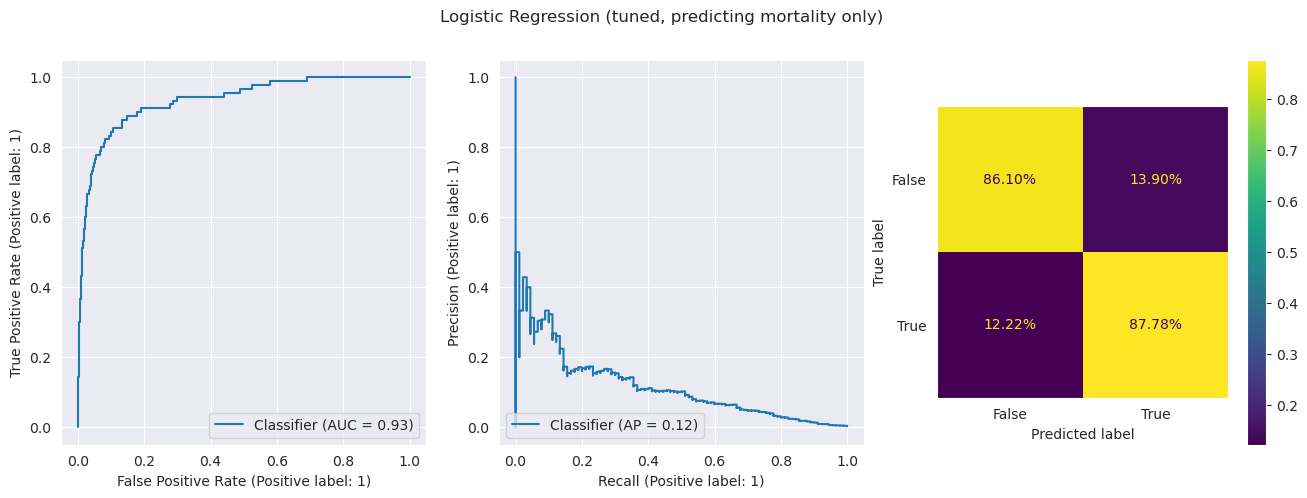

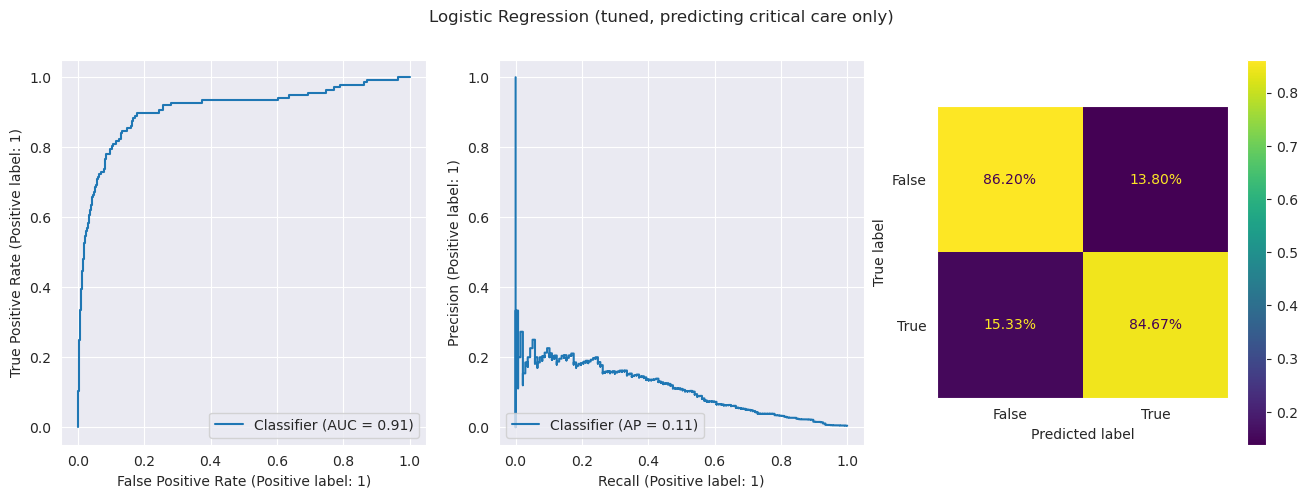

In [20]:
print("Mortality")
Notebook.MORTALITY_RESULTS[modelkey] = evaluate_from_pred(
    y_test_mortality,
    y_pred,
    y_pred_proba,
    plot_title="Logistic Regression (tuned, predicting mortality only)",
    save=f"{Notebook.IMAGE_DIR}/eval_mortality_thresholded_logistic_regression.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)

print("Critical Care")
Notebook.CRITICALCARE_RESULTS[modelkey] = evaluate_from_pred(
    y_test_criticalcare,
    y_pred,
    y_pred_proba,
    plot_title="Logistic Regression (tuned, predicting critical care only)",
    save=f"{Notebook.IMAGE_DIR}/eval_criticalcare_thresholded_logistic_regression.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

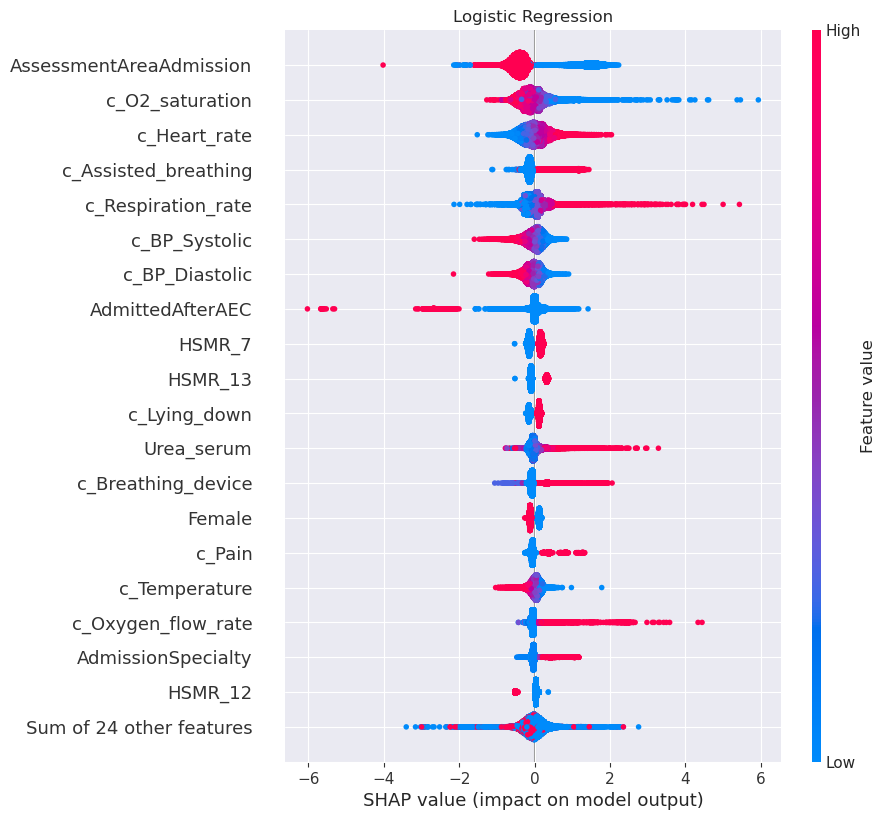

In [21]:
explainer = shap.LinearExplainer(
    model["LR"], X_train, feature_perturbation="correlation_dependent"
)
shap_values = explainer(X_test)
Notebook.EXPLAINERS[modelkey] = (explainer, shap_values)

fig = shap.plots.beeswarm(
    shap_values, max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("Logistic Regression")

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/shap_swarm_logistic_regression.png", bbox_inches="tight"
    )


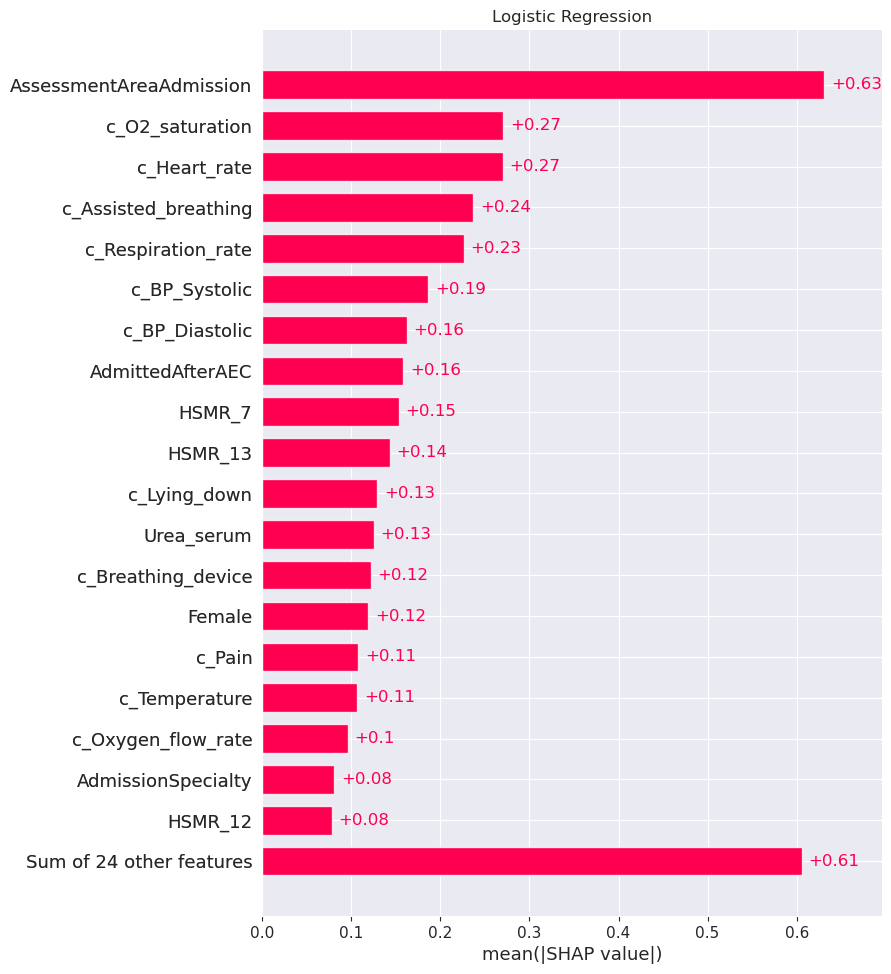

In [22]:
fig = shap.plots.bar(
    shap_values, max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("Logistic Regression")

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/shap_bar_logistic_regression.png", bbox_inches="tight"
    )


### Random Forest

In [23]:
rf_params = {
    "RF__n_estimators": 250,
    "RF__max_features": 0.56,
    "RF__min_samples_split": 8,
    "RF__min_samples_leaf": 3,
    "RF__max_samples": 0.75,
    "RF__class_weight": "balanced",
    "IMB__sampling_strategy": 0.14,
}

if Notebook.RUN_HYPERPARAMETERS:
    rf_params.update(
        tune_randomforest(
            X_train,
            y_train,
            timeout=Notebook.HYPERPARAMETER_TIMEOUT,
            n_jobs=Notebook.HYPERPARAMETER_NJOBS,
        )
    )



BEST PARAMETERS
{'RF__n_estimators': 200, 'RF__max_features': 0.2638961287048745, 'RF__min_samples_split': 5, 'RF__min_samples_leaf': 11, 'RF__max_samples': 0.9221209449409655, 'RF__class_weight': 'balanced', 'IMB__sampling_strategy': 0.10040011953810496}


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.941997    0.08515  0.774194  0.153425  0.295671  0.943437   

            AUC_CI  
Model  0.926-0.959

array([[29942,  1805],
       [   49,   168]])

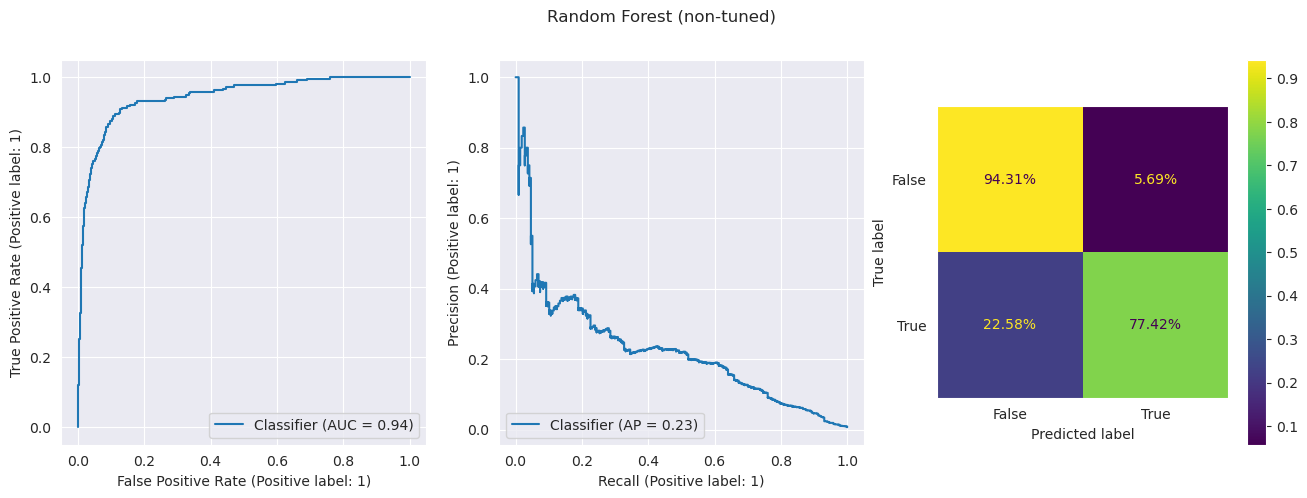

In [24]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler

modelkey = "Random Forest"
model = (
    ImbPipeline(steps=[("IMB", RandomUnderSampler()), ("RF", RandomForestClassifier())])
    .set_params(**rf_params)
    .fit(X_train.to_numpy(), y_train)
)

Notebook.MODELS[modelkey] = model

Notebook.EVAL_RESULTS[modelkey] = evaluate(
    model,
    X_test.to_numpy(),
    y_test,
    plot_title="Random Forest (non-tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_random_forest.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)



Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.900294   0.056716  0.875576  0.106532  0.225225  0.943437   

            AUC_CI  
Model  0.926-0.959

array([[28587,  3160],
       [   27,   190]])

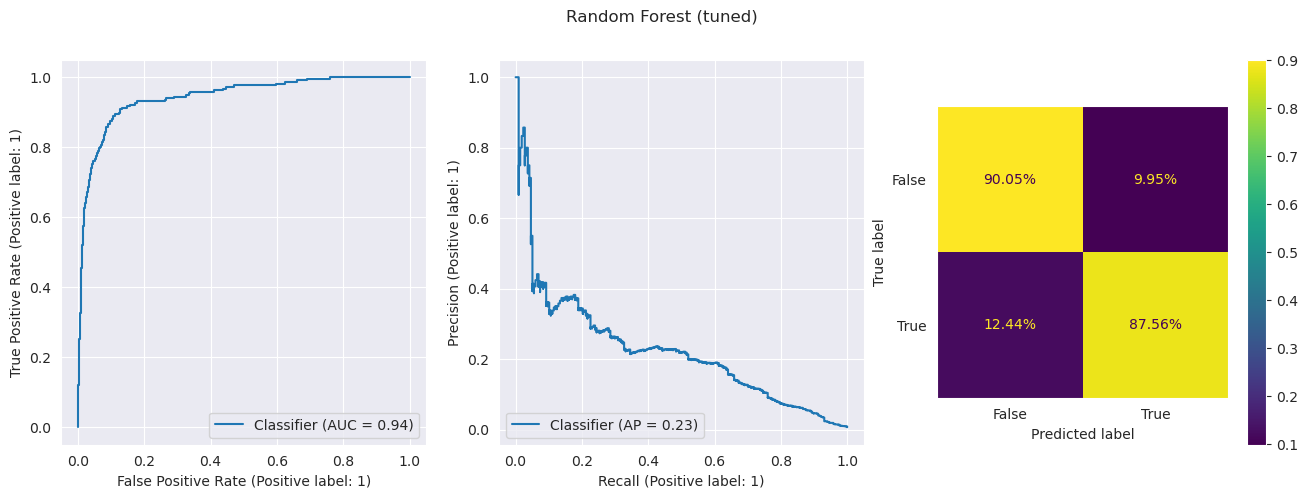

In [25]:
threshold = get_threshold(y_train, model.predict_proba(X_train.to_numpy())[:, 1],)

# Create predictions on the test set, using this new threshold
y_pred_proba = model.predict_proba(X_test.to_numpy())[:, 1]
y_pred = np.where(y_pred_proba > 1 - threshold, 1, 0)

# Produce scores
Notebook.TUNED_RESULTS[modelkey] = evaluate_from_pred(
    y_test,
    y_pred,
    y_pred_proba,
    plot_title="Random Forest (tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_thresholded_random_forest.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


Mortality


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.897197   0.022985  0.855556  0.044767  0.103774  0.939345   

            AUC_CI  
Model  0.908-0.965

array([[28601,  3273],
       [   13,    77]])

Critical Care


Accuracy  Precision   Recall  F1 Score  F2 Score       AUC       AUC_CI
Model  0.898605   0.036716  0.89781  0.070548  0.157773  0.946792  0.927-0.964

array([[28600,  3227],
       [   14,   123]])

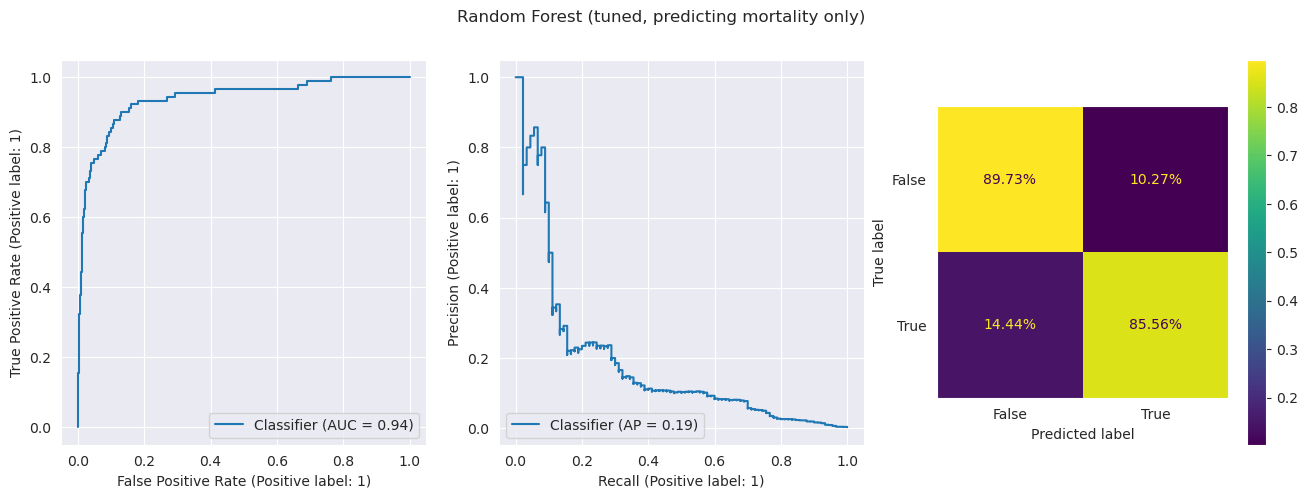

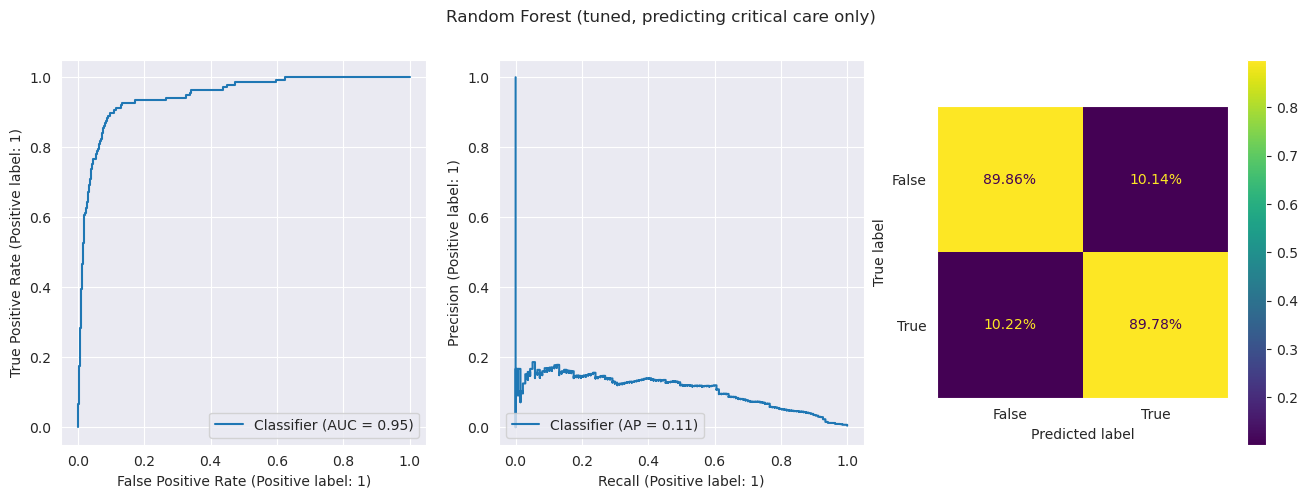

In [26]:
print("Mortality")
Notebook.MORTALITY_RESULTS[modelkey] = evaluate_from_pred(
    y_test_mortality,
    y_pred,
    y_pred_proba,
    plot_title="Random Forest (tuned, predicting mortality only)",
    save=f"{Notebook.IMAGE_DIR}/eval_mortality_thresholded_random_forest.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)

print("Critical Care")
Notebook.CRITICALCARE_RESULTS[modelkey] = evaluate_from_pred(
    y_test_criticalcare,
    y_pred,
    y_pred_proba,
    plot_title="Random Forest (tuned, predicting critical care only)",
    save=f"{Notebook.IMAGE_DIR}/eval_criticalcare_thresholded_random_forest.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


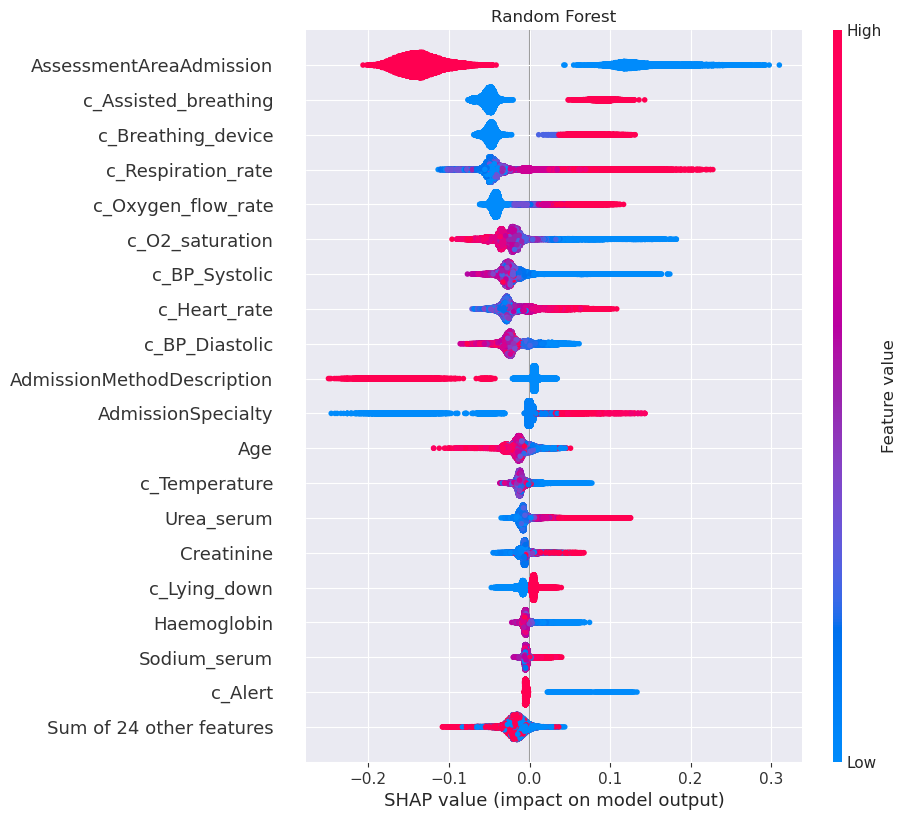

In [27]:
explainer = shap.TreeExplainer(model["RF"])
shap_values = explainer(X_test)
Notebook.EXPLAINERS[modelkey] = (explainer, shap_values)

fig = shap.plots.beeswarm(
    shap_values[:, :, 1], max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("Random Forest")

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/shap_swarm_random_forest.png", bbox_inches="tight"
    )


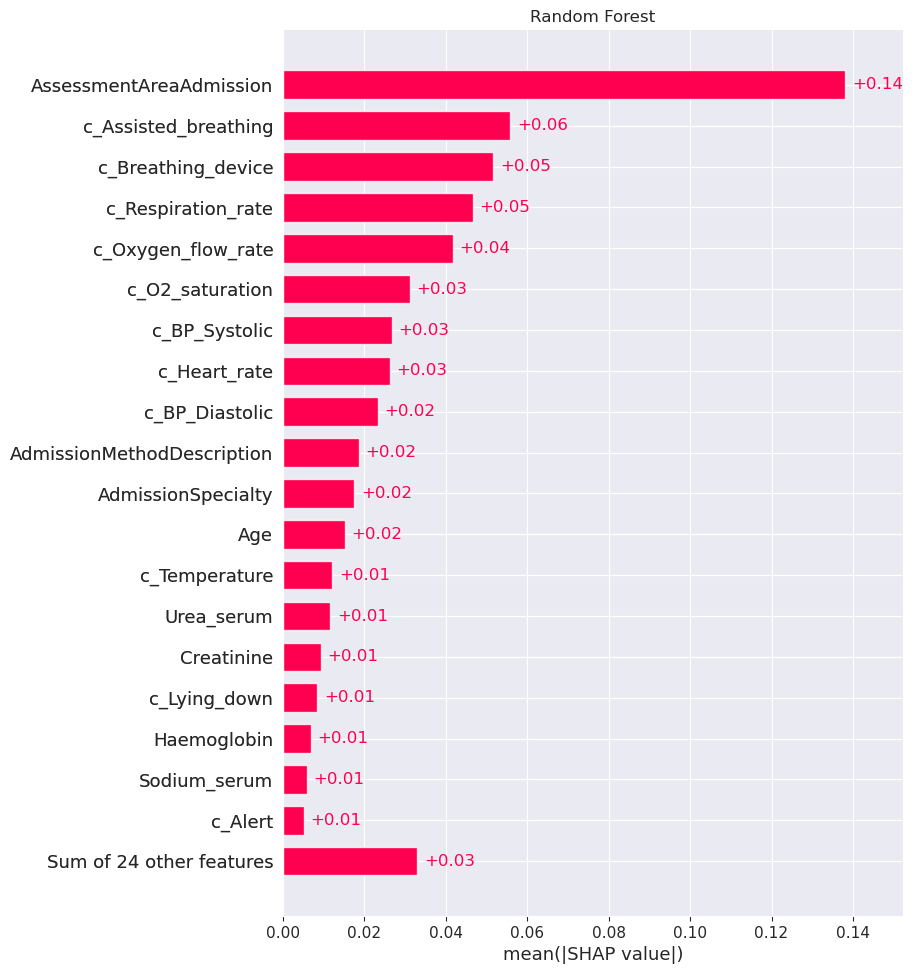

In [28]:
fig = shap.plots.bar(
    shap_values[:, :, 1], max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("Random Forest")

if Notebook.SAVE_IMAGES:
    plt.savefig(f"{Notebook.IMAGE_DIR}/shap_bar_random_forest.png", bbox_inches="tight")


### XGBoost

In [29]:
xgboost_params = {
    "XGB__verbosity": 0,
    "XGB__n_jobs": 1,
    "XGB__missing": -1,
    "XGB__objective": "binary:logistic",
    "XGB__enable_categorical": True,
    "XGB__tree_method": "hist",
    "XGB__missing": -1,
    "XGB__booster": "gbtree",
    "XGB__lambda": 7e-2,
    "XGB__alpha": 7e-05,
    "XGB__subsample": 0.42,
    "XGB__colsample_bytree": 0.87,
    "XGB__scale_pos_weight": 14,
    "XGB__max_depth": 7,
    "XGB__min_child_weight": 10,
    "XGB__eta": 0.034,
    "XGB__gamma": 4e-08,
    "XGB__grow_policy": "lossguide",
    "IMB__sampling_strategy": 0.1,
}


if Notebook.RUN_HYPERPARAMETERS:
    xgboost_params.update(
        tune_xgboost(
            X_train_lgbm,
            y_train_lgbm,
            timeout=Notebook.HYPERPARAMETER_TIMEOUT,
            n_jobs=Notebook.HYPERPARAMETER_NJOBS,
        )
    )



BEST PARAMETERS
{'XGB__tree_method': 'approx', 'XGB__lambda': 1.7089347008275346e-08, 'XGB__alpha': 0.05522585895405917, 'XGB__subsample': 0.5665204748396445, 'XGB__colsample_bytree': 0.8462443563559215, 'XGB__scale_pos_weight': 4, 'IMB__sampling_strategy': 0.17597089110001476, 'XGB__max_depth': 5, 'XGB__min_child_weight': 4, 'XGB__eta': 0.04563423173804828, 'XGB__gamma': 3.7573524420589123e-06, 'XGB__grow_policy': 'lossguide'}


Accuracy  Precision   Recall  F1 Score  F2 Score      AUC       AUC_CI
Model  0.941622   0.087956  0.81106  0.158702  0.306727  0.95032  0.936-0.964

array([[29922,  1825],
       [   41,   176]])

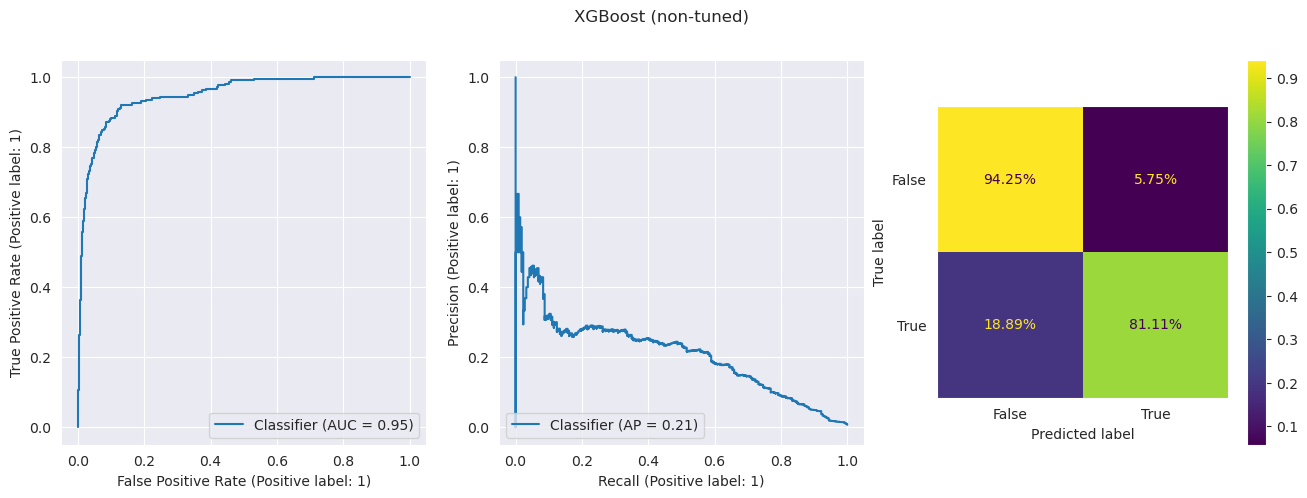

In [30]:
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler

modelkey = "XGBoost"
model = (
    ImbPipeline(steps=[("IMB", RandomUnderSampler()), ("XGB", XGBClassifier()),])
    .set_params(**xgboost_params)
    .fit(X_train_lgbm, y_train_lgbm)
)

Notebook.MODELS[modelkey] = model

Notebook.EVAL_RESULTS[modelkey] = evaluate(
    model,
    X_test_lgbm,
    y_test_lgbm,
    "XGBoost (non-tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_xgboost.png" if Notebook.SAVE_IMAGES else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


Accuracy  Precision    Recall  F1 Score  F2 Score      AUC       AUC_CI
Model  0.914842   0.065255  0.866359  0.121369  0.250734  0.95032  0.936-0.964

array([[29054,  2693],
       [   29,   188]])

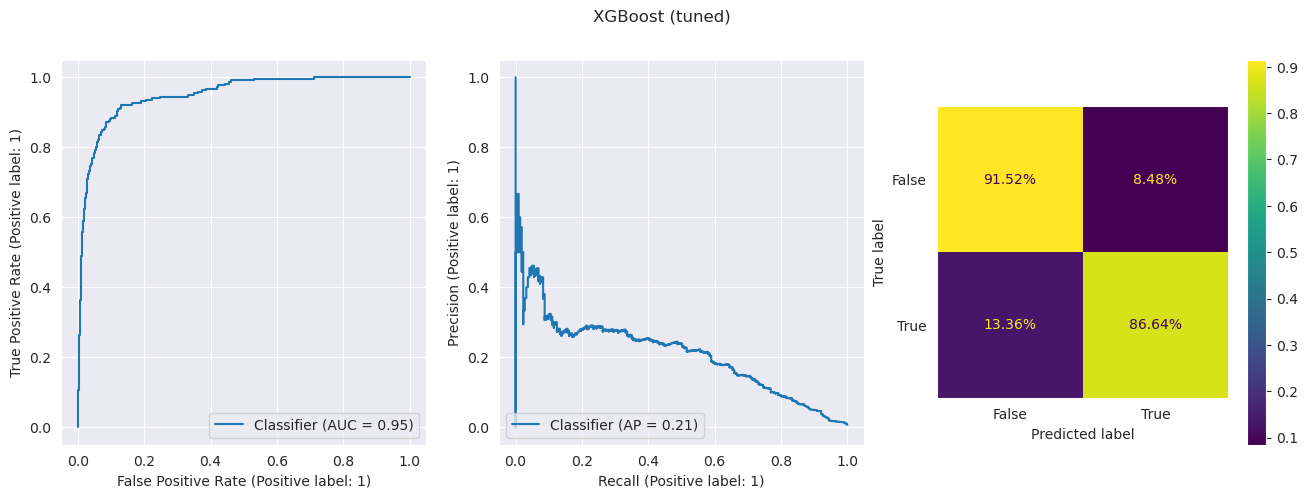

In [31]:
threshold = get_threshold(y_train_lgbm, model.predict_proba(X_train_lgbm)[:, 1],)

# Create predictions on the test set, using this new threshold
y_pred_proba = model.predict_proba(X_test_lgbm)[:, 1]
y_pred = np.where(y_pred_proba > 1 - threshold, 1, 0)

# Produce scores
Notebook.TUNED_RESULTS[modelkey] = evaluate_from_pred(
    y_test_lgbm,
    y_pred,
    y_pred_proba,
    plot_title="XGBoost (tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_thresholded_xgboost.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


Mortality


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.911932   0.027074  0.866667  0.052508  0.120333  0.950444   

            AUC_CI  
Model  0.925-0.970

array([[29071,  2803],
       [   12,    78]])

Critical Care


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model   0.91309   0.041652  0.875912  0.079523  0.174978  0.950525   

            AUC_CI  
Model  0.933-0.966

array([[29066,  2761],
       [   17,   120]])

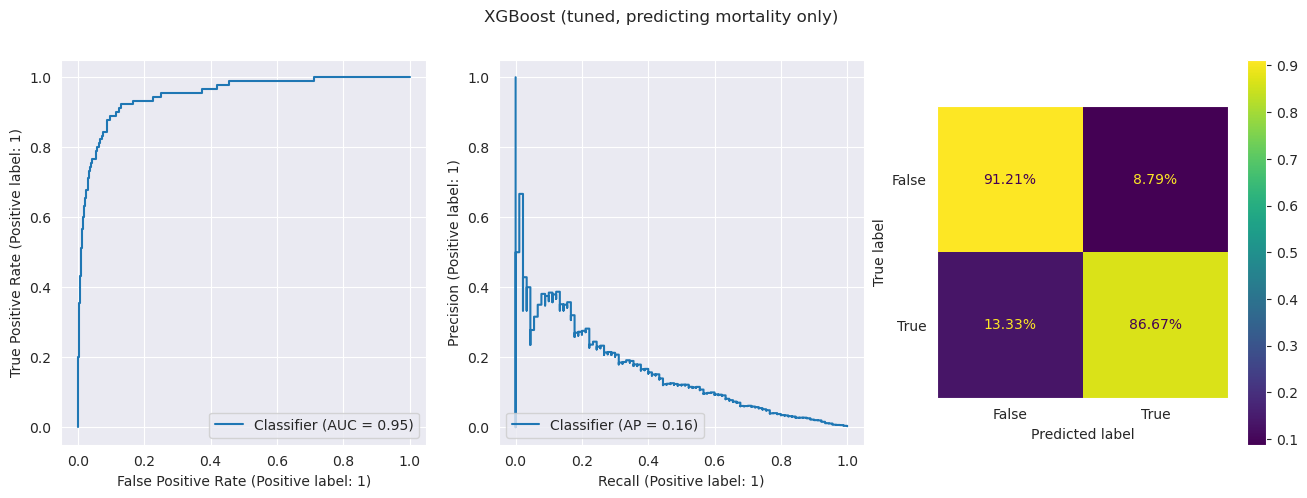

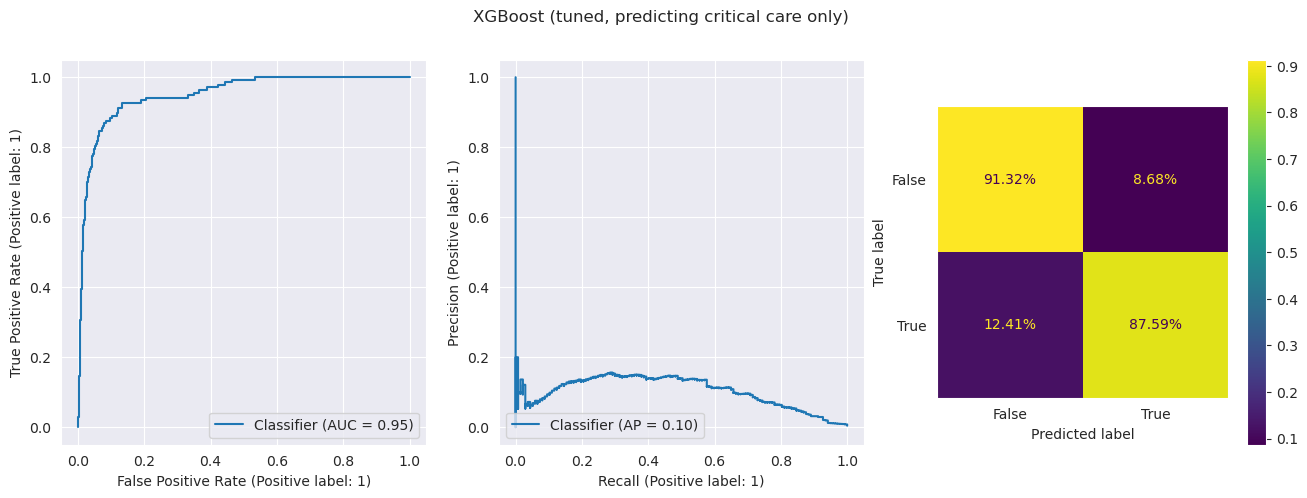

In [32]:
print("Mortality")
Notebook.MORTALITY_RESULTS[modelkey] = evaluate_from_pred(
    y_test_mortality,
    y_pred,
    y_pred_proba,
    plot_title="XGBoost (tuned, predicting mortality only)",
    save=f"{Notebook.IMAGE_DIR}/eval_mortality_thresholded_xgboost.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)

print("Critical Care")
Notebook.CRITICALCARE_RESULTS[modelkey] = evaluate_from_pred(
    y_test_criticalcare,
    y_pred,
    y_pred_proba,
    plot_title="XGBoost (tuned, predicting critical care only)",
    save=f"{Notebook.IMAGE_DIR}/eval_criticalcare_thresholded_xgboost.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


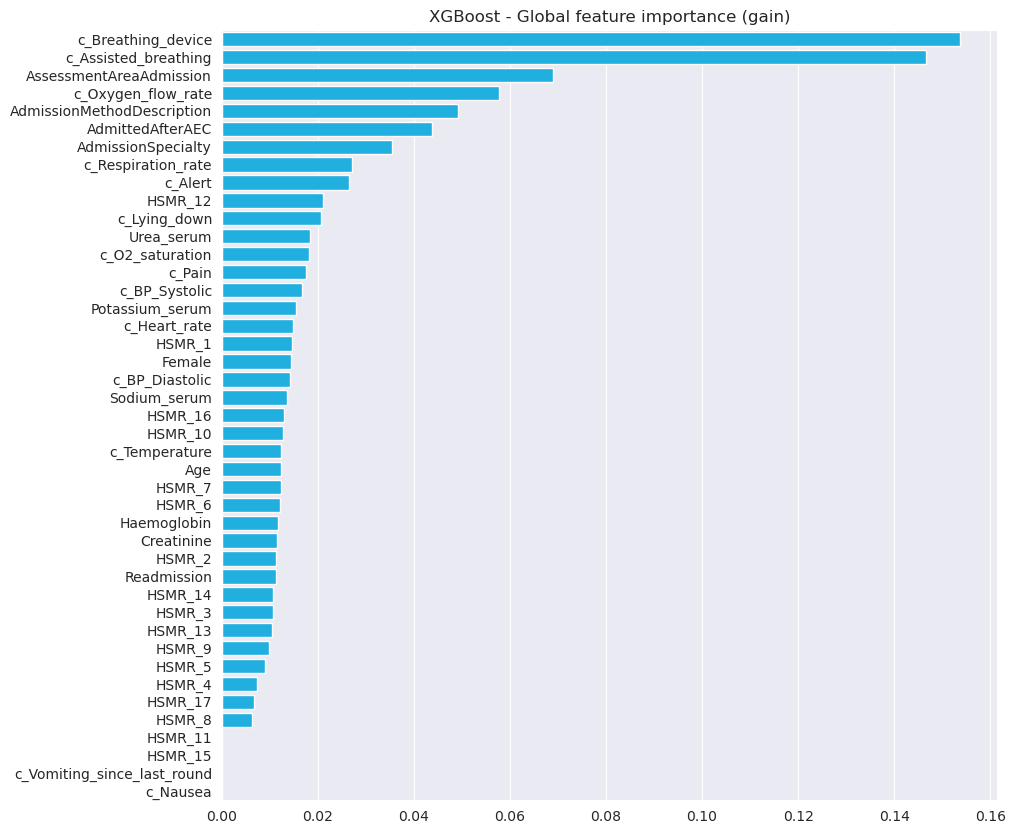

In [33]:
sorted_idx = model["XGB"].feature_importances_.argsort()[::-1]
fig, ax = plt.subplots(1,1,figsize=(10,10))
sns.barplot(
    x=model["XGB"].feature_importances_[sorted_idx],
    y=X_train.columns[sorted_idx],
    color="deepskyblue",
    ax=ax
)
ax.set_title("XGBoost - Global feature importance (gain)")

if Notebook.SAVE_IMAGES:
    plt.savefig(f"{Notebook.IMAGE_DIR}/global_weights_xgboost.png", bbox_inches="tight")



ntree_limit is deprecated, use `iteration_range` or model slicing instead.


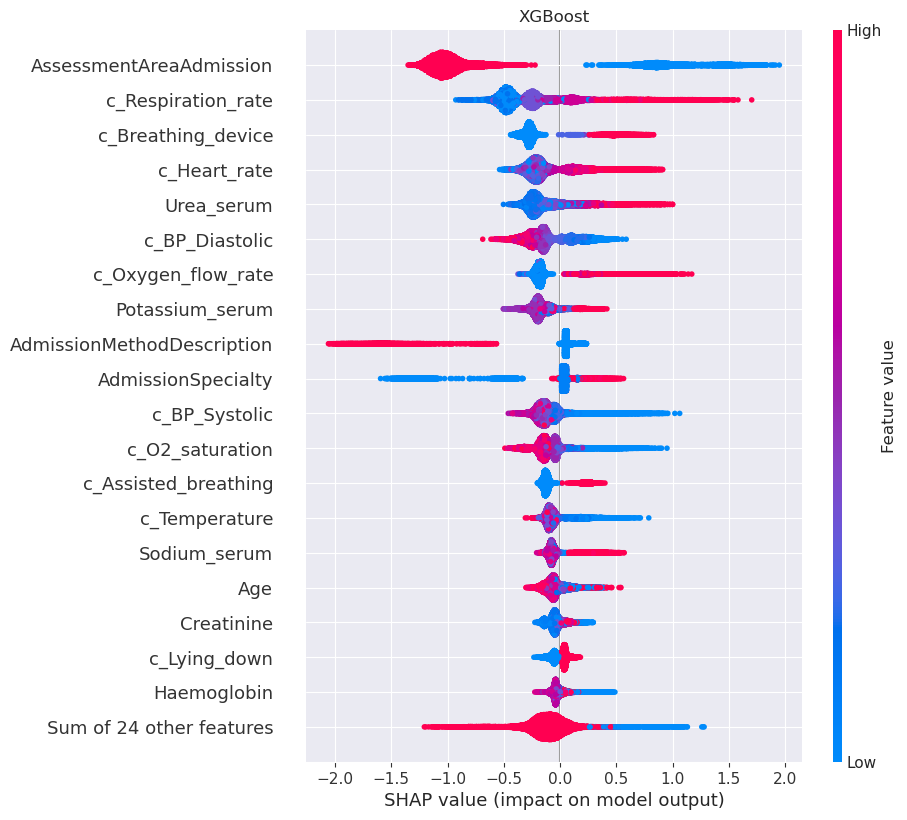

In [34]:
explainer = shap.TreeExplainer(model["XGB"])
shap_values = explainer(X_test)
Notebook.EXPLAINERS[modelkey] = (explainer, shap_values)

fig = shap.plots.beeswarm(
    shap_values, max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("XGBoost")

if Notebook.SAVE_IMAGES:
    plt.savefig(f"{Notebook.IMAGE_DIR}/shap_swarm_xgboost.png", bbox_inches="tight")


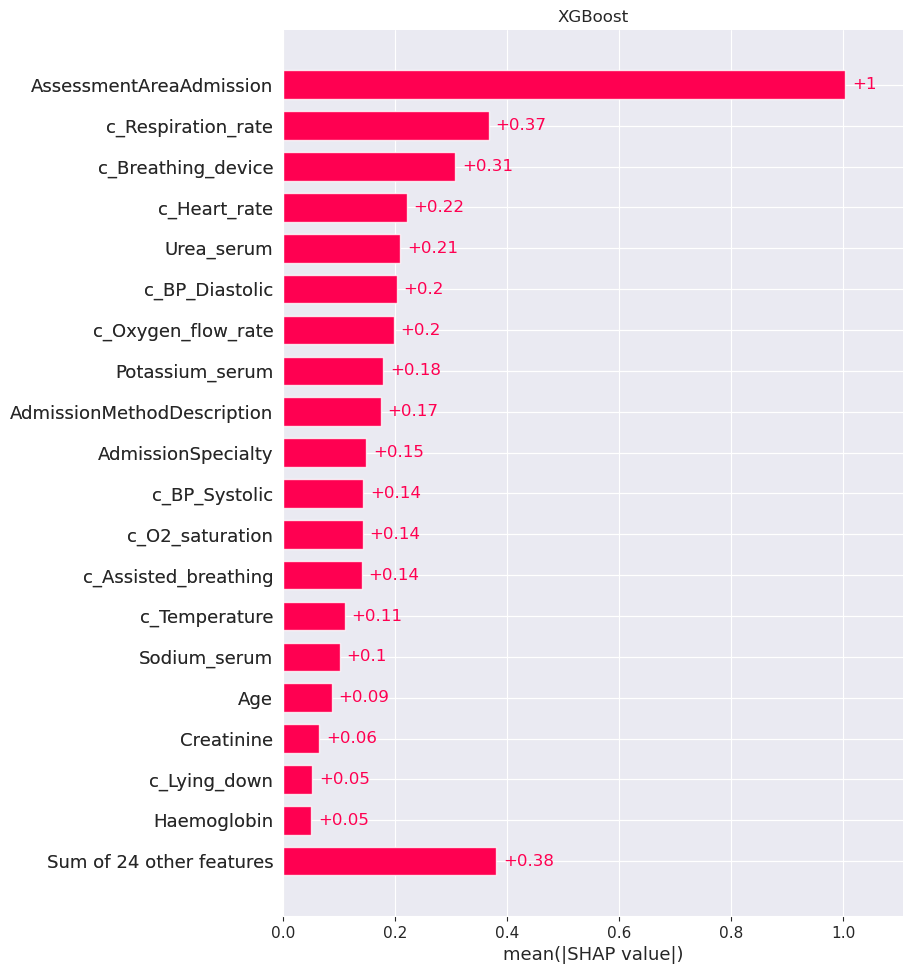

In [35]:
fig = shap.plots.bar(
    shap_values, max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("XGBoost")

if Notebook.SAVE_IMAGES:
    plt.savefig(f"{Notebook.IMAGE_DIR}/shap_bar_xgboost.png", bbox_inches="tight")


### LightGBM

In [36]:
lgbm_params = {
    "LGBM__objective": "binary",
    "LGBM__metrics": ["l2", "auc"],
    "LGBM__boosting_type": "gbdt",
    "LGBM__is_unbalance": True,
    "LGBM__n_jobs": 1,
    "LGBM__feature_pre_filter": False,
    "LGBM__lambda_l1": 0.15,
    "LGBM__lambda_l2": 3.2,
    "LGBM__num_leaves": 225,
    "LGBM__feature_fraction": 0.8,
    "LGBM__bagging_fraction": 0.8,
    "LGBM__bagging_freq": 7,
    "LGBM__min_child_samples": 45,
    "IMB__sampling_strategy": 0.1,
}

if Notebook.RUN_HYPERPARAMETERS:
    lgbm_params.update(
        tune_lgbm(
            X_train_lgbm,
            y_train_lgbm,
            categorical_cols_idx,
            timeout=Notebook.HYPERPARAMETER_TIMEOUT,
            n_jobs=Notebook.HYPERPARAMETER_NJOBS,
        )
    )


[LightGBM] [Warning] feature_fraction is set=0.5668979274348361, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5668979274348361
[LightGBM] [Warning] lambda_l1 is set=0.0012195691724185835, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0012195691724185835
[LightGBM] [Warning] bagging_fraction is set=0.8490451100843948, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8490451100843948
[LightGBM] [Warning] lambda_l2 is set=0.0027058212993741463, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0027058212993741463
[LightGBM] [Warning] feature_fraction is set=0.7997305273839348, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7997305273839348[LightGBM] [Warning] 
[LightGBM] [Warning] lambda_l1 is set=0.004986976909950576, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004986976909950576
feature_fraction is set=0.48750499989966994, colsample_bytree=1.0 will be ignored. Current value: feature_fr

categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
categorical_feature in param dict is overridden.


[LightGBM] [Warning] feature_fraction is set=0.44947737733731064, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44947737733731064
[LightGBM] [Warning] lambda_l1 is set=5.047247920935732e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.047247920935732e-06
[LightGBM] [Warning] bagging_fraction is set=0.4458210851075855, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4458210851075855
[LightGBM] [Warning] lambda_l2 is set=7.390165781540293e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.390165781540293e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.993369368628736, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.993369368628736
[LightGBM] [Warning] lambda_l1 is set=7.458352500693992, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.458352500693992
[LightGBM] [Warning] baggin

[LightGBM] [Warning] feature_fraction is set=0.5824014100688623, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5824014100688623
[LightGBM] [Warning] lambda_l1 is set=0.00045389931074023006, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00045389931074023006
[LightGBM] [Warning] bagging_fraction is set=0.992885010491957, subsample=1.0 will be ignored. Current value: bagging_fraction=0.992885010491957
[LightGBM] [Warning] lambda_l2 is set=3.191878582611947, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.191878582611947
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


Accuracy  Precision    Recall  F1 Score  F2 Score      AUC       AUC_CI
Model  0.918283   0.068157  0.870968  0.126421  0.259544  0.94745  0.930-0.963

array([[29163,  2584],
       [   28,   189]])

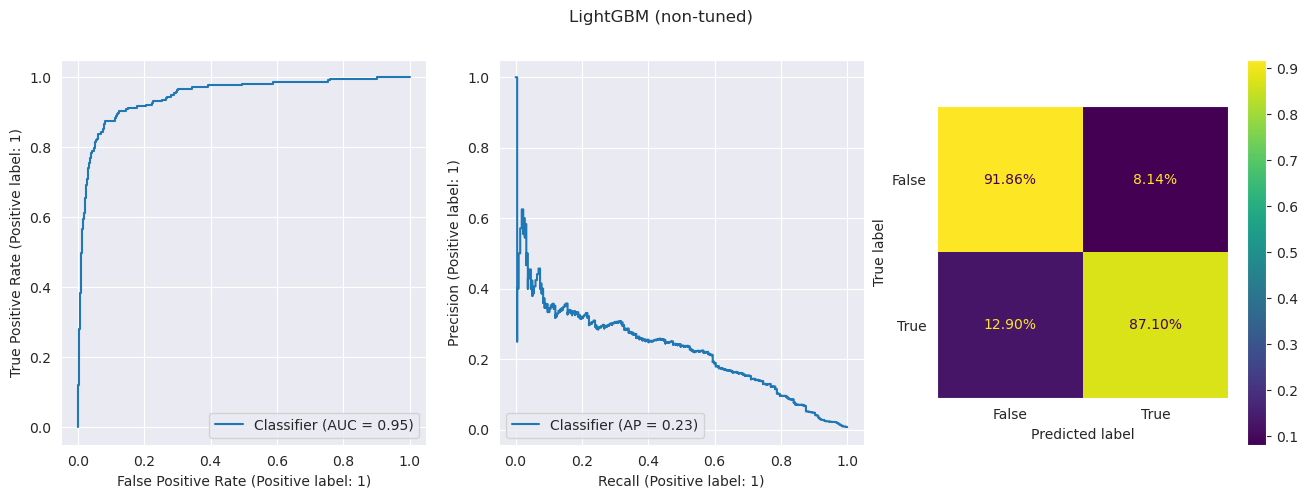

In [37]:
from lightgbm import LGBMClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler

modelkey = "LightGBM"

model = (
    ImbPipeline(steps=[("IMB", RandomUnderSampler()), ("LGBM", LGBMClassifier()),])
    .set_params(**lgbm_params)
    .fit(
        X_train_lgbm,
        y_train_lgbm,
        LGBM__categorical_feature=categorical_cols_idx,
        LGBM__feature_name=list(X_train.columns),
    )
)

Notebook.MODELS[modelkey] = model

Notebook.EVAL_RESULTS[modelkey] = evaluate(
    model,
    X_test_lgbm,
    y_test_lgbm,
    plot_title="LightGBM (non-tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_lightgbm.png" if Notebook.SAVE_IMAGES else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


Accuracy  Precision    Recall  F1 Score  F2 Score      AUC       AUC_CI
Model   0.92307   0.070498  0.847926  0.130173   0.26452  0.94745  0.930-0.963

array([[29321,  2426],
       [   33,   184]])

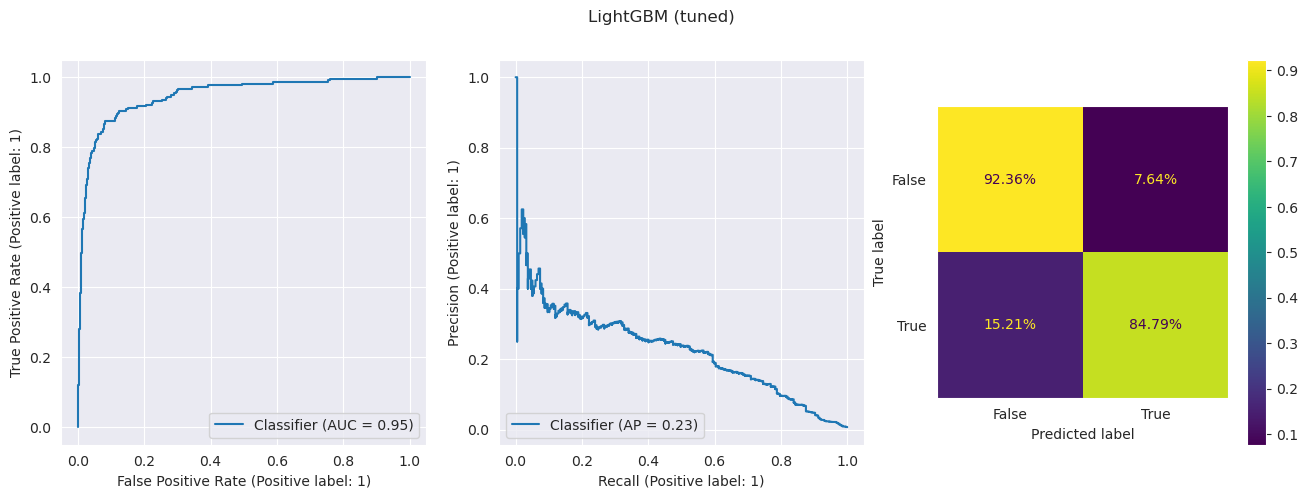

In [38]:
threshold = get_threshold(y_test_lgbm, model.predict_proba(X_test_lgbm)[:, 1],)

# Create predictions on the test set, using this new threshold
y_pred_proba = model.predict_proba(X_test_lgbm)[:, 1]
y_pred = np.where(y_pred_proba > threshold, 1, 0)

Notebook.TUNED_RESULTS[modelkey] = evaluate_from_pred(
    y_test_lgbm,
    y_pred,
    y_pred_proba,
    plot_title="LightGBM (tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_thresholded_lightgbm.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


Mortality


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.920536   0.030651  0.888889  0.059259   0.13468  0.956651   

            AUC_CI  
Model  0.933-0.974

array([[29344,  2530],
       [   10,    80]])

Critical Care


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.921193   0.043678  0.832117     0.083  0.180494  0.942109   

            AUC_CI  
Model  0.918-0.962

array([[29331,  2496],
       [   23,   114]])

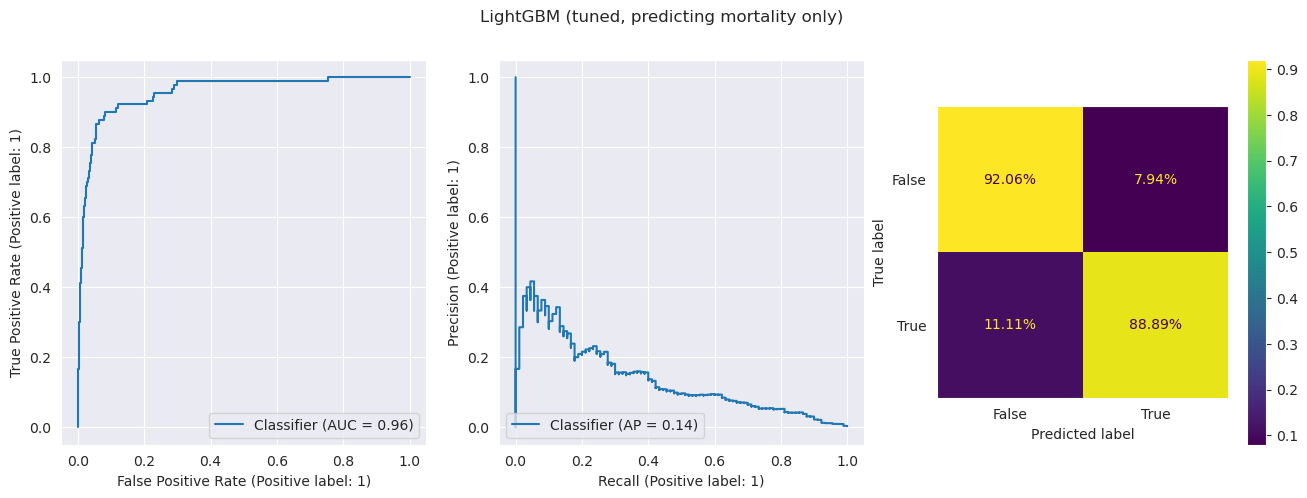

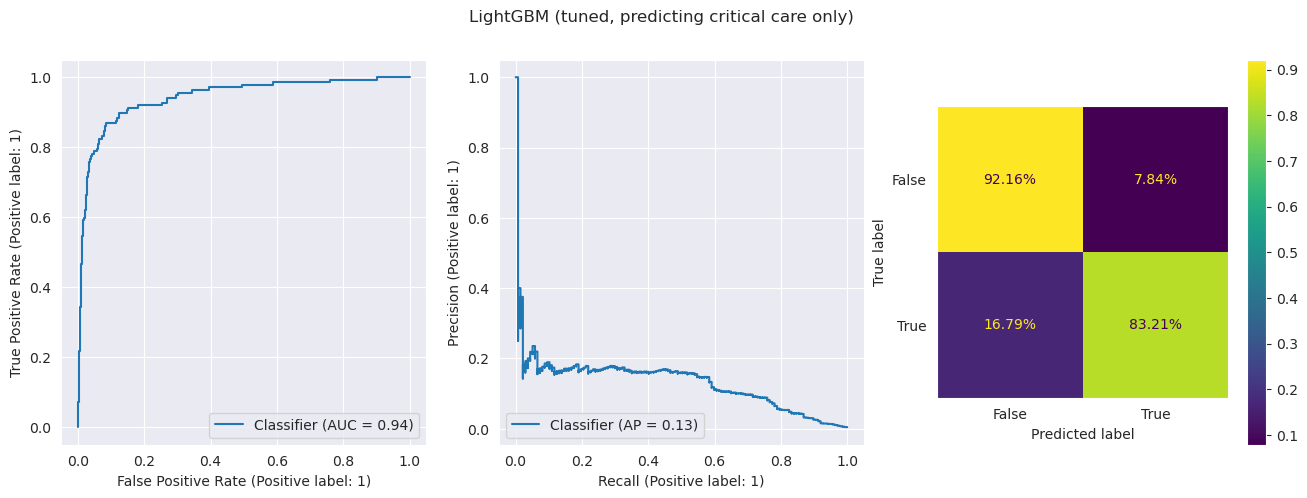

In [39]:
print("Mortality")
Notebook.MORTALITY_RESULTS[modelkey] = evaluate_from_pred(
    y_test_mortality,
    y_pred,
    y_pred_proba,
    plot_title="LightGBM (tuned, predicting mortality only)",
    save=f"{Notebook.IMAGE_DIR}/eval_mortality_thresholded_lightgbm.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)

print("Critical Care")
Notebook.CRITICALCARE_RESULTS[modelkey] = evaluate_from_pred(
    y_test_criticalcare,
    y_pred,
    y_pred_proba,
    plot_title="LightGBM (tuned, predicting critical care only)",
    save=f"{Notebook.IMAGE_DIR}/eval_criticalcare_thresholded_lightgbm.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


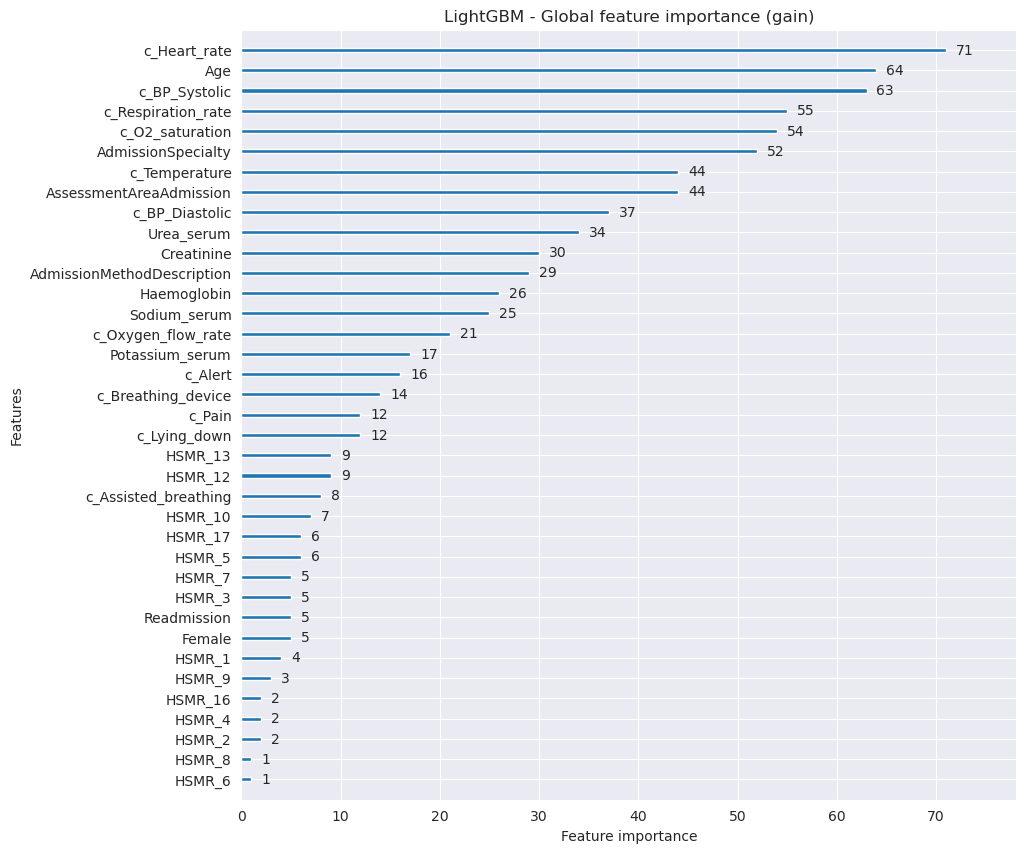

In [40]:
import lightgbm as lgb

fig = lgb.plot_importance(model["LGBM"], figsize=(10, 10))
fig.set_title("LightGBM - Global feature importance (gain)")

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/global_weights_lightgbm.png", bbox_inches="tight"
    )


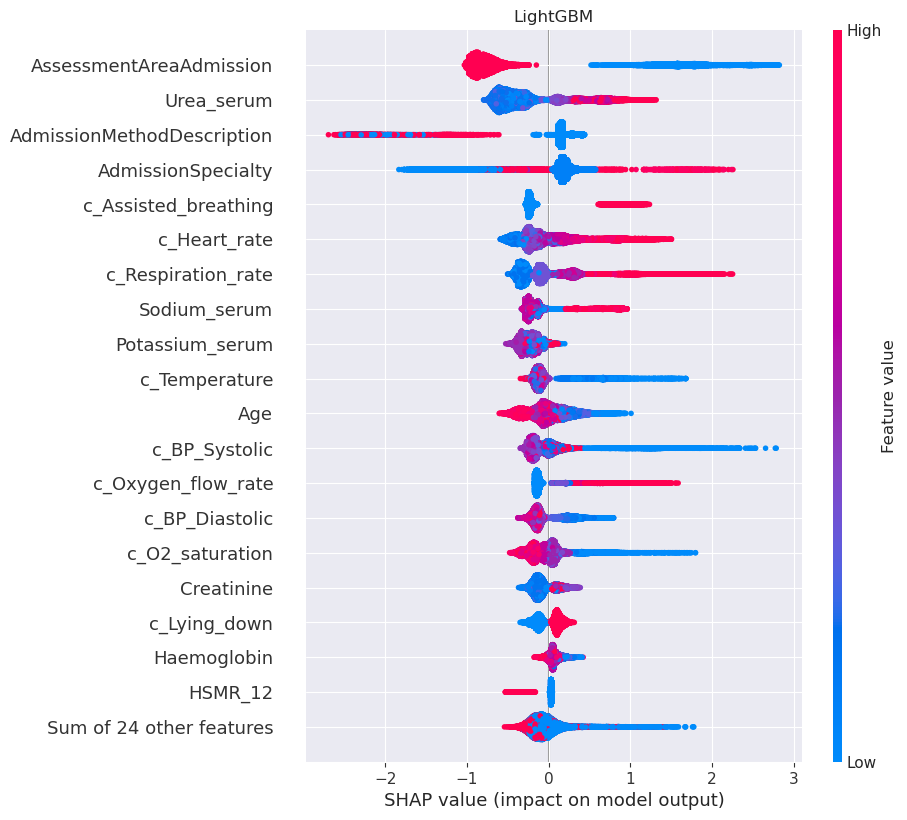

In [41]:
explainer = shap.TreeExplainer(model["LGBM"])
shap_values = explainer(X_test)
Notebook.EXPLAINERS[modelkey] = (explainer, shap_values)

fig = shap.plots.beeswarm(
    shap_values[:, :, 1], max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("LightGBM")
if Notebook.SAVE_IMAGES:
    plt.savefig(f"{Notebook.IMAGE_DIR}/shap_swarm_lightgbm.png", bbox_inches="tight")


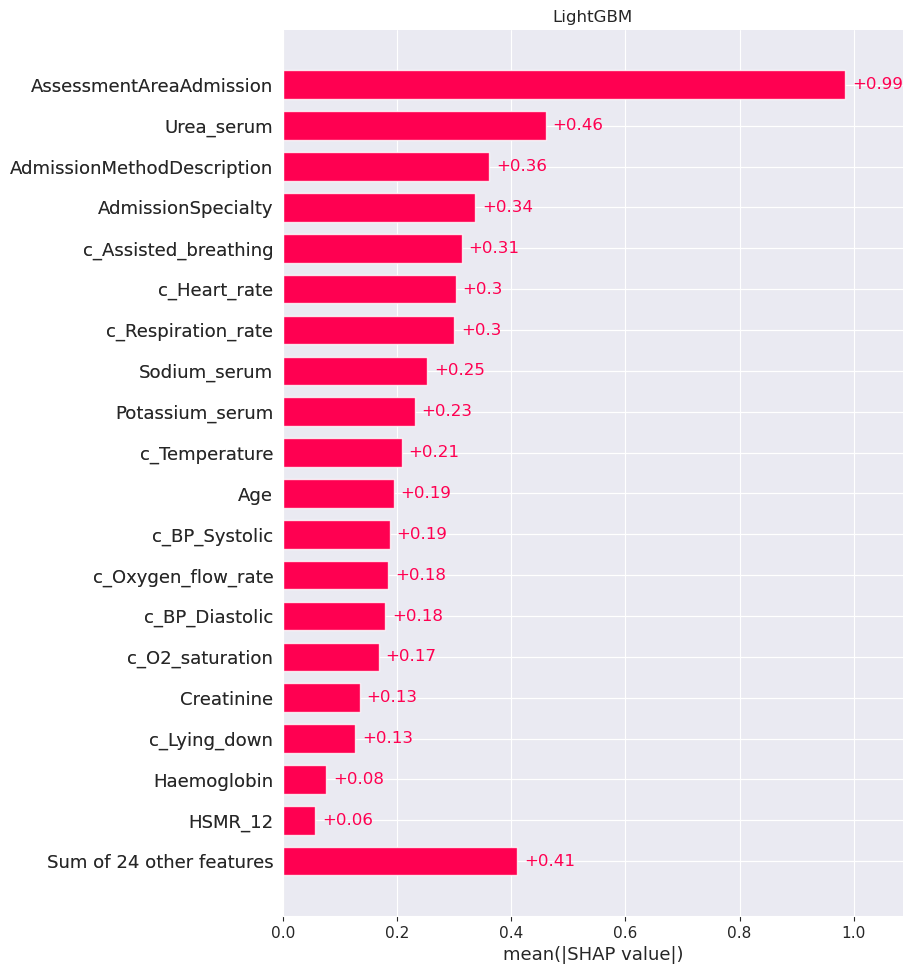

In [42]:
fig = shap.plots.bar(
    shap_values[:, :, 1], max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("LightGBM")

if Notebook.SAVE_IMAGES:
    plt.savefig(f"{Notebook.IMAGE_DIR}/shap_bar_lightgbm.png", bbox_inches="tight")


### Isolation Forest

In [43]:
if_params = {
    "n_estimators": 140,
    "max_samples": 0.465,
    "contamination": 0.0213,
    "max_features": 0.69,
    "bootstrap": False,
}

if Notebook.RUN_HYPERPARAMETERS:
    if_params = tune_isolationforest(
        X_train_if,
        y_train_if,
        timeout=Notebook.HYPERPARAMETER_TIMEOUT,
        n_jobs=Notebook.HYPERPARAMETER_NJOBS,
    )



BEST PARAMETERS
{'n_estimators': 137, 'max_samples': 0.009626071378219858, 'contamination': 0.09094574648213377, 'max_features': 0.9693295365095517, 'bootstrap': True}


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.883557   0.039905  0.700461  0.075509  0.162497  0.867229   

            AUC_CI  
Model  0.840-0.892

array([[28090,  3657],
       [   65,   152]])

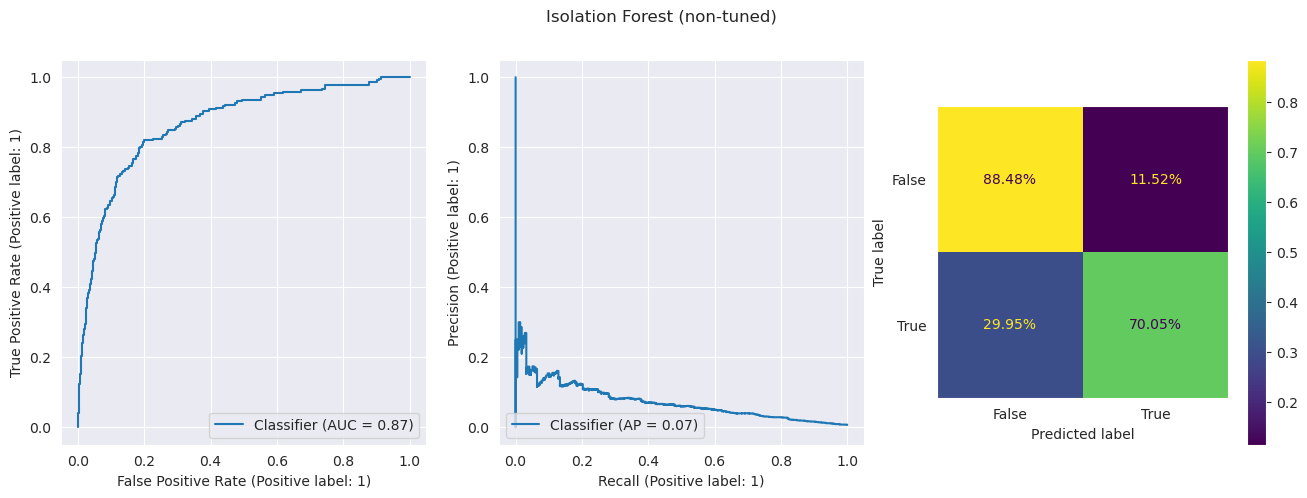

In [44]:
modelkey = "Isolation Forest"

model = IsolationForestWrapper(**if_params).fit(X_train_if[~y_train_if].to_numpy())
Notebook.MODELS[modelkey] = model

Notebook.EVAL_RESULTS[modelkey] = evaluate(
    model,
    X_test_if.to_numpy(),
    y_test_if,
    plot_title="Isolation Forest (non-tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_isolation_forest.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.616381   0.015759  0.903226  0.030978  0.073657  0.867229   

            AUC_CI  
Model  0.840-0.892

array([[19506, 12241],
       [   21,   196]])

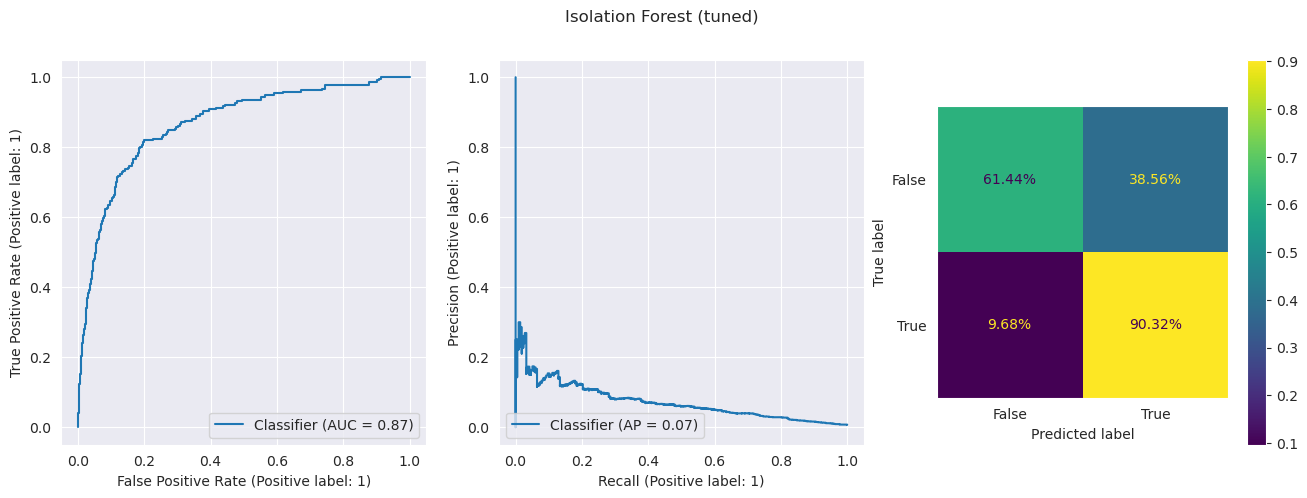

In [45]:
y_pred_proba_train = model.decision_function(X_train_if)
y_pred_proba_train -= y_pred_proba_train.min()

threshold = get_threshold(y_train_if, y_pred_proba_train,)

# Create predictions on the test set, using this new threshold
y_pred_proba = model.decision_function(X_test_if)
y_pred = np.where(y_pred_proba - y_pred_proba.min() > threshold, 1, 0)

Notebook.TUNED_RESULTS[modelkey] = evaluate_from_pred(
    y_test_if,
    y_pred,
    y_pred_proba,
    plot_title="Isolation Forest (tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_thresholded_isolation_forest.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


Mortality


Accuracy  Precision    Recall  F1 Score  F2 Score      AUC       AUC_CI
Model  0.613346   0.006754  0.933333  0.013411   0.03282  0.90191  0.860-0.937

array([[19521, 12353],
       [    6,    84]])

Critical Care


Accuracy  Precision    Recall  F1 Score  F2 Score      AUC       AUC_CI
Model  0.614254   0.009809  0.890511  0.019405  0.046977  0.84823  0.814-0.879

array([[19512, 12315],
       [   15,   122]])

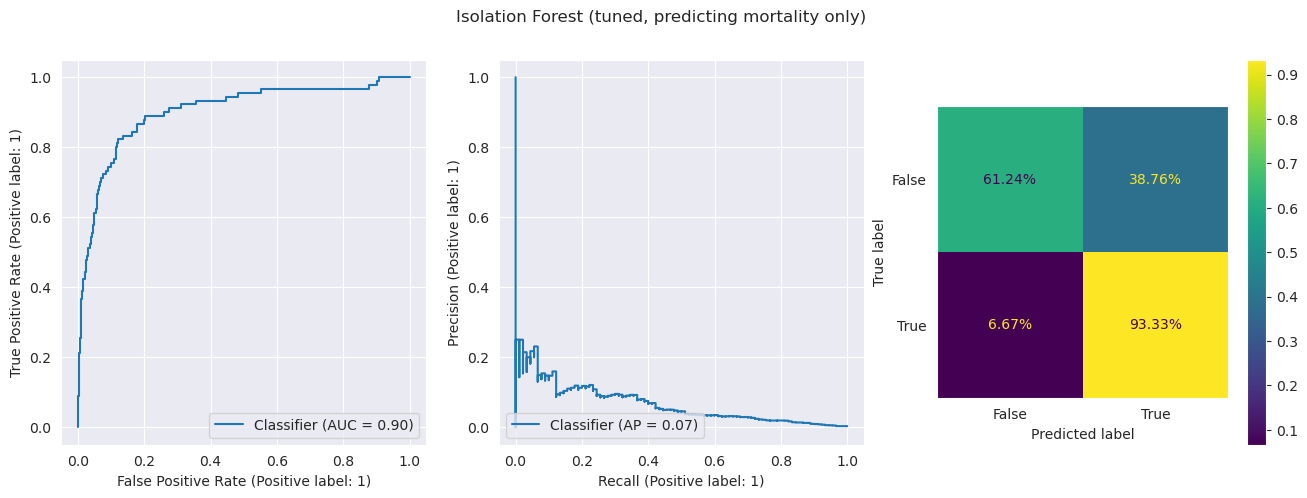

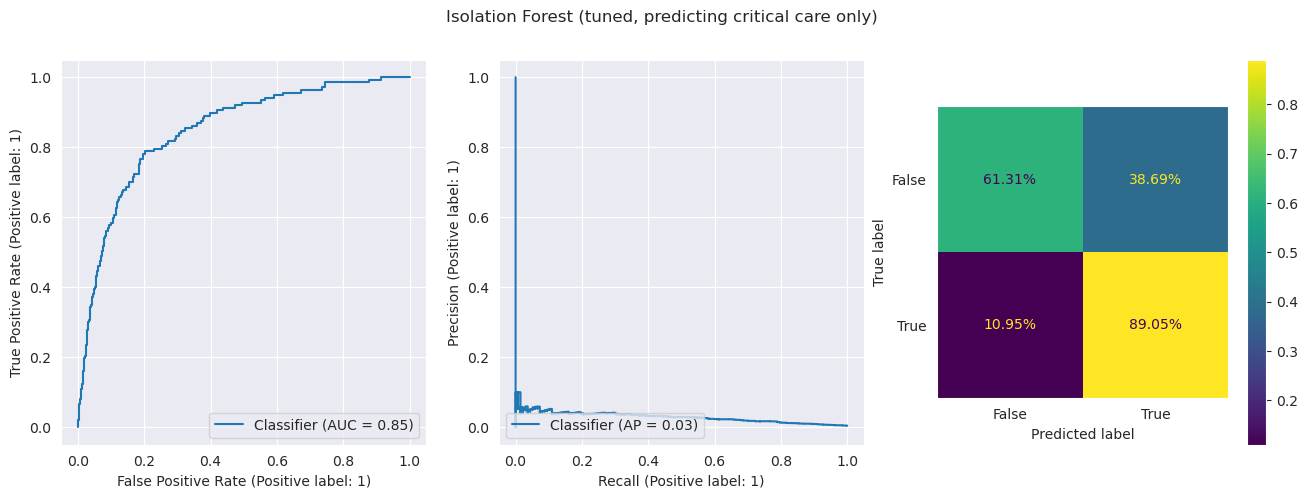

In [46]:
print("Mortality")
Notebook.MORTALITY_RESULTS[modelkey] = evaluate_from_pred(
    y_test_mortality,
    y_pred,
    y_pred_proba,
    plot_title="Isolation Forest (tuned, predicting mortality only)",
    save=f"{Notebook.IMAGE_DIR}/eval_mortality_thresholded_isolation_forest.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)

print("Critical Care")
Notebook.CRITICALCARE_RESULTS[modelkey] = evaluate_from_pred(
    y_test_criticalcare,
    y_pred,
    y_pred_proba,
    plot_title="Isolation Forest (tuned, predicting critical care only)",
    save=f"{Notebook.IMAGE_DIR}/eval_criticalcare_thresholded_isolation_forest.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


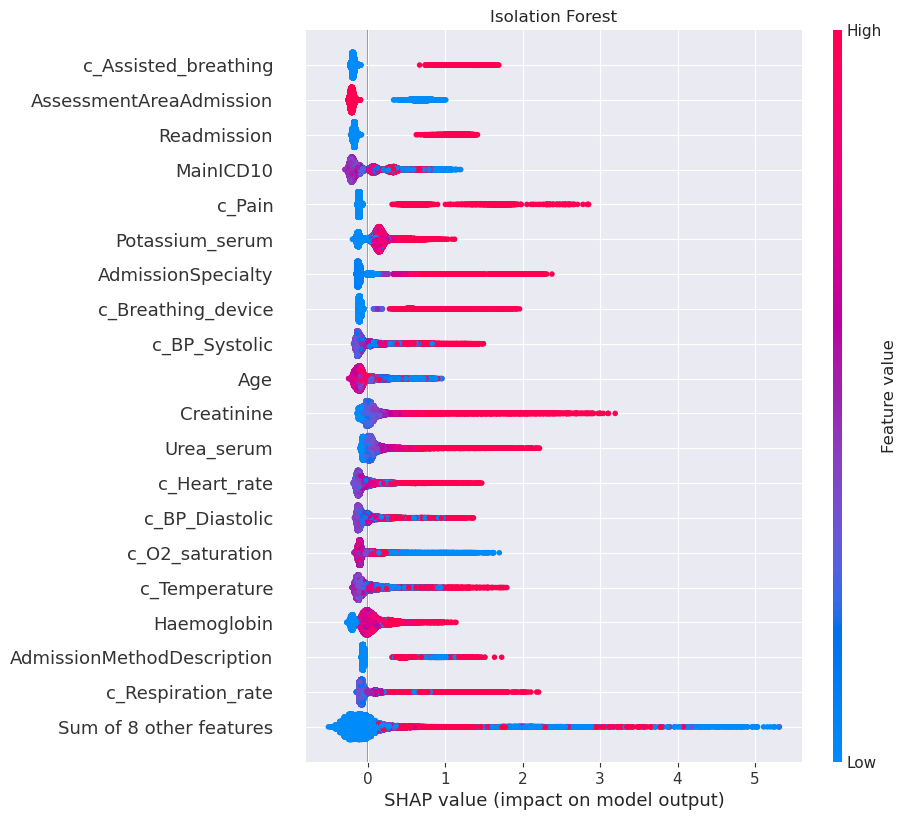

In [47]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test_if)
shap_values.values = -shap_values.values  # Fix for isolation forest's unique labelling
Notebook.EXPLAINERS[modelkey] = (explainer, shap_values)

fig = shap.plots.beeswarm(
    shap_values, max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("Isolation Forest")

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/shap_swarm_isolation_forest.png", bbox_inches="tight"
    )



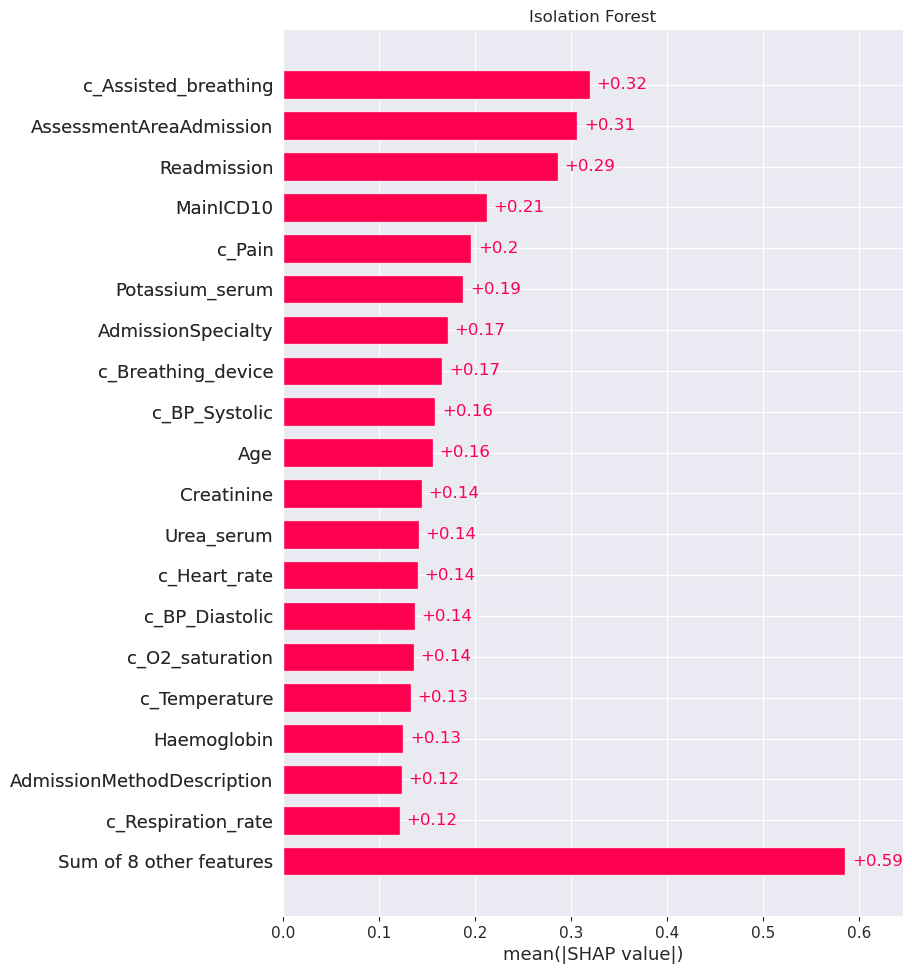

In [48]:
fig = shap.plots.bar(
    shap_values, max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("Isolation Forest")

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/shap_bar_isolation_forest.png", bbox_inches="tight"
    )



### TabNet

In [49]:
import torch
from pytorch_tabnet.tab_model import TabNetClassifier

tabnet_params = dict(
    cat_idxs=categorical_cols_idx,
    cat_dims=categorical_cols_dims,
    n_a=64,
    n_d=64,
    n_steps=3,
    gamma=1.0,
    lambda_sparse=9e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=0.02, weight_decay=1e-05),
    mask_type="sparsemax",
    n_shared=1,
    scheduler_params=dict(mode="min", patience=5, min_lr=1e-05, factor=0.5,),
    scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
    verbose=0,
    device_name="cuda" if torch.cuda.is_available() else "cpu",
)

if Notebook.RUN_HYPERPARAMETERS:
    returned_params, tabnet_patience, tabnet_scheduler_patience = tune_tabnet(
        X_train,
        y_train,
        categorical_cols_idx,
        categorical_cols_dims,
        timeout=Notebook.HYPERPARAMETER_TIMEOUT,
        n_jobs=Notebook.HYPERPARAMETER_NJOBS,
    )

    tabnet_params.update(returned_params)
    tabnet_params["scheduler_params"]["patience"] = tabnet_scheduler_patience




Early stopping occurred at epoch 29 with best_epoch = 7 and best_val_0_auc = 0.82299
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 33 with best_epoch = 11 and best_val_0_auc = 0.86151
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 22 with best_epoch = 0 and best_val_0_auc = 0.81635
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 39 with best_epoch = 17 and best_val_0_auc = 0.85078
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 26 with best_epoch = 4 and best_val_0_auc = 0.83992
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 30 with best_epoch = 13 and best_val_0_auc = 0.82709
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 20 with best_epoch = 3 and best_val_0_auc = 0.85347
Best weights from best epoch are automatically used!

Early stopping occurred


Early stopping occurred at epoch 37 with best_epoch = 14 and best_valid_auc = 0.86663
Best weights from best epoch are automatically used!


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.975097   0.115538  0.400922  0.179381  0.268353  0.859885   

            AUC_CI  
Model  0.828-0.889

array([[31081,   666],
       [  130,    87]])

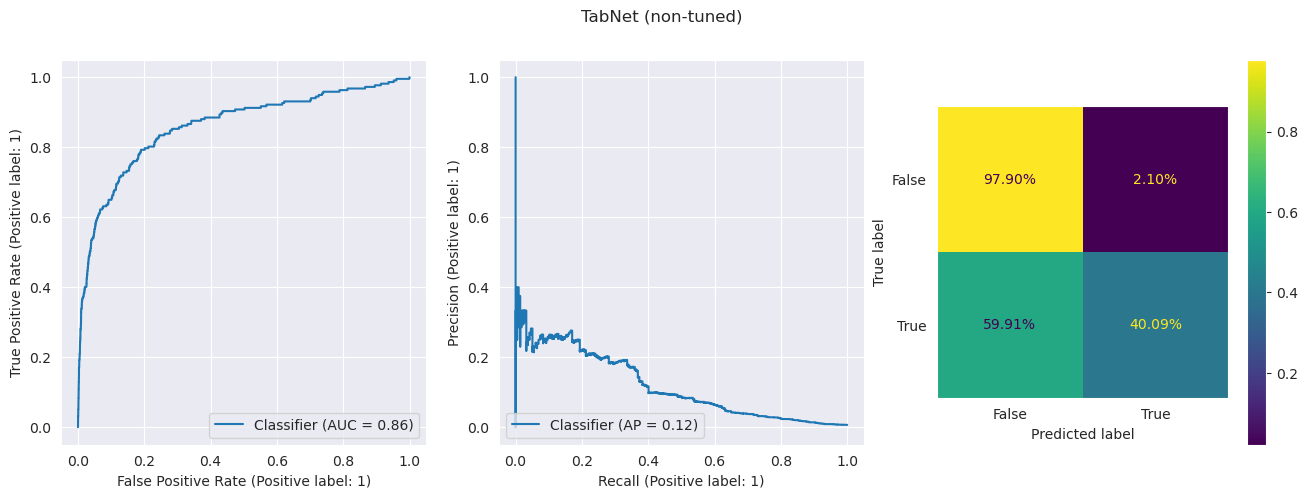

In [50]:
modelkey = "TabNet"
model = TabNetClassifier(**tabnet_params)
model.fit(
    X_train=X_train_tn,
    y_train=y_train_tn,
    eval_set=[(X_train_tn, y_train_tn), (X_valid_tn, y_valid_tn)],
    eval_name=["train", "valid"],
    eval_metric=["auc"],
    max_epochs=100,
    patience=tabnet_patience,
    # batch_size=512,
    # virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False,
)

Notebook.MODELS[modelkey] = model

Notebook.EVAL_RESULTS[modelkey] = evaluate(
    model,
    X_test.to_numpy(),
    y_test,
    "TabNet (non-tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_tabnet.png" if Notebook.SAVE_IMAGES else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


Accuracy  Precision   Recall  F1 Score  F2 Score       AUC       AUC_CI
Model  0.811288    0.02762  0.78341  0.053358  0.121031  0.859885  0.828-0.889

array([[25762,  5985],
       [   47,   170]])

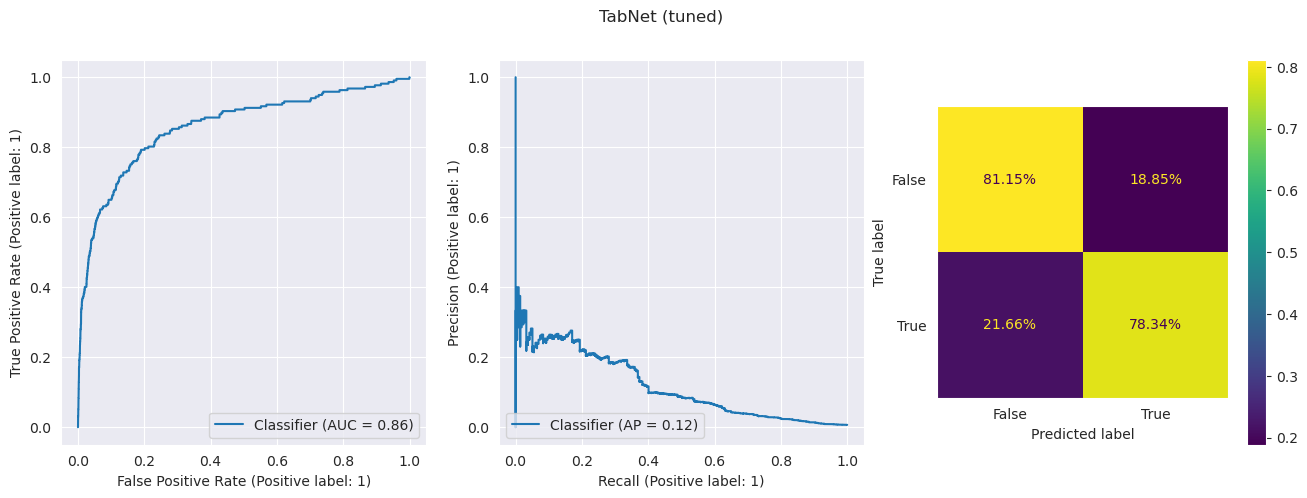

In [51]:
threshold = get_threshold(
    y_test, model.predict_proba(X_test.to_numpy())[:, 1], target=0.785
)

# Create predictions on the test set, using this new threshold
y_pred_proba = model.predict_proba(X_test.to_numpy())[:, 1]
y_pred = np.where(y_pred_proba > threshold, 1, 0)

Notebook.TUNED_RESULTS[modelkey] = evaluate_from_pred(
    y_test,
    y_pred,
    y_pred_proba,
    plot_title="TabNet (tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_thresholded_tabnet.png"
    if Notebook.SAVE_IMAGES
    else None,
)


Mortality


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.809004   0.011373  0.777778  0.022418  0.053722  0.872256   

            AUC_CI  
Model  0.828-0.912

array([[25789,  6085],
       [   20,    70]])

Critical Care


Accuracy  Precision   Recall  F1 Score  F2 Score       AUC       AUC_CI
Model  0.809974   0.017709  0.79562  0.034647  0.081307  0.855409  0.814-0.893

array([[25781,  6046],
       [   28,   109]])

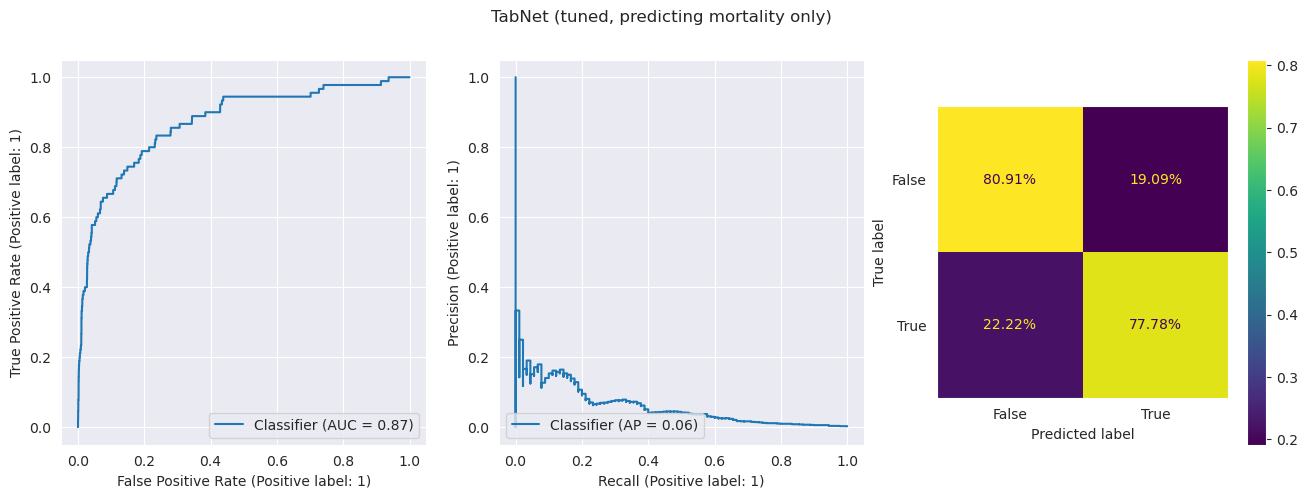

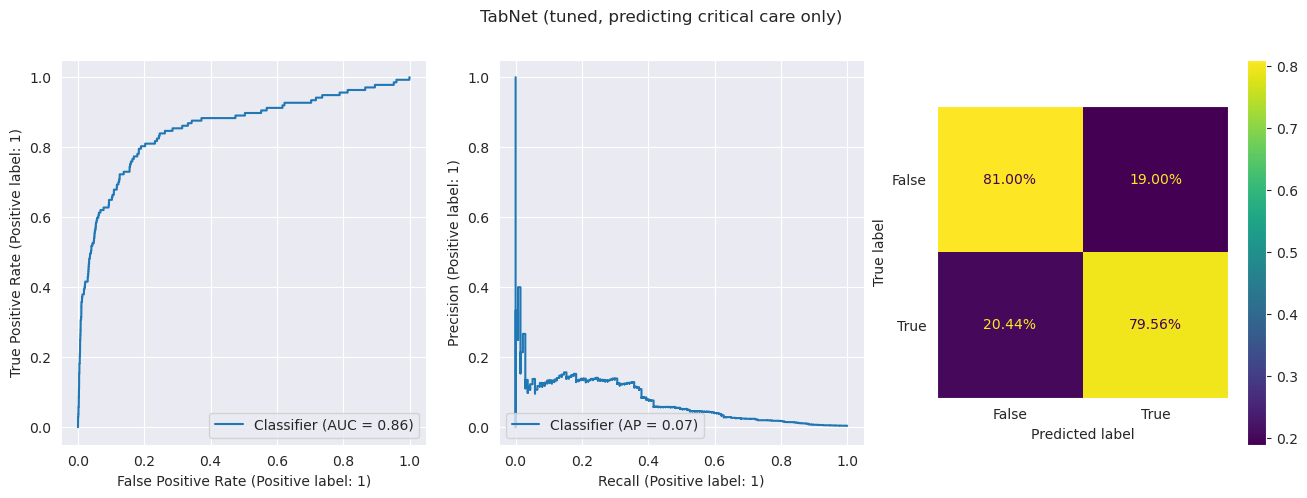

In [52]:
print("Mortality")
Notebook.MORTALITY_RESULTS[modelkey] = evaluate_from_pred(
    y_test_mortality,
    y_pred,
    y_pred_proba,
    plot_title="TabNet (tuned, predicting mortality only)",
    save=f"{Notebook.IMAGE_DIR}/eval_mortality_thresholded_tabnet.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)

print("Critical Care")
Notebook.CRITICALCARE_RESULTS[modelkey] = evaluate_from_pred(
    y_test_criticalcare,
    y_pred,
    y_pred_proba,
    plot_title="TabNet (tuned, predicting critical care only)",
    save=f"{Notebook.IMAGE_DIR}/eval_criticalcare_thresholded_tabnet.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


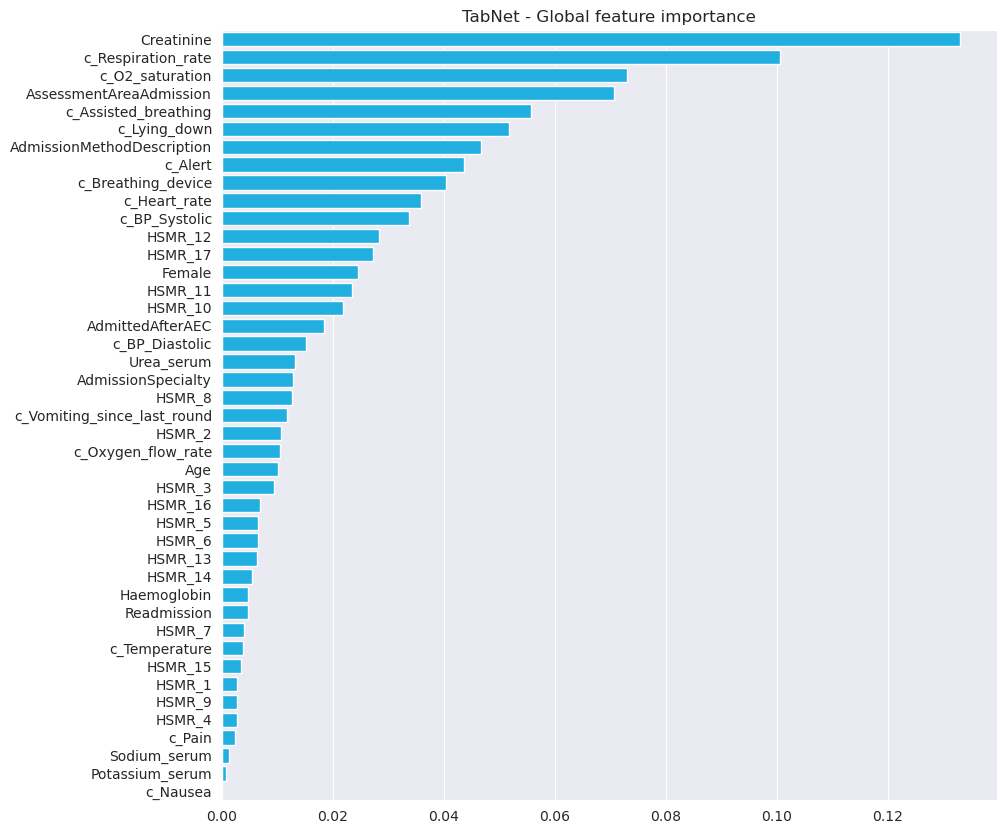

In [53]:
sorted_idx = model.feature_importances_.argsort()[::-1]
fig, ax = plt.subplots(1,1,figsize=(10,10))
sns.barplot(
    x=model.feature_importances_[sorted_idx],
    y=X_train.columns[sorted_idx],
    color="deepskyblue",
    ax=ax
)
ax.set_title("TabNet - Global feature importance")

if Notebook.SAVE_IMAGES:
    plt.savefig(f"{Notebook.IMAGE_DIR}/global_weights_tabnet.png", bbox_inches="tight")



Using 1361 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/15000 [00:00<?, ?it/s]

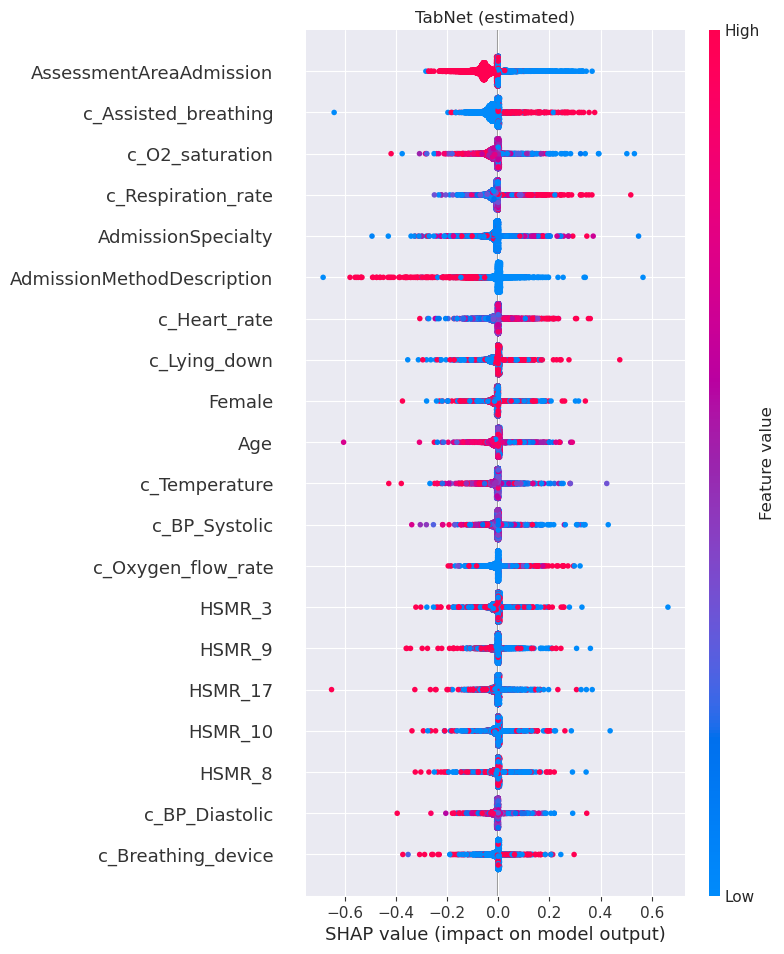

In [54]:
X_test_tn_shap = shap.sample(X_test.to_numpy(), 15000)
explainer = shap.KernelExplainer(model.predict_proba, np.concatenate((shap.sample(X_train_tn[~y_train_tn], 1000), X_train_tn[y_train_tn])))
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    shap_values = explainer.shap_values(X_test_tn_shap, nsamples=50)

Notebook.EXPLAINERS[modelkey] = (explainer, shap_values)

shap.summary_plot(
    shap_values[1],
    X_test_tn_shap,
    feature_names=X_test.columns,
    show=False,
    max_display=Notebook.SHAP_PLOTS_MAXDISPLAY,
    plot_type="dot",
)
plt.title("TabNet (estimated)")

if Notebook.SAVE_IMAGES:
    plt.savefig(f"{Notebook.IMAGE_DIR}/shap_swarm_tabnet.png", bbox_inches="tight")


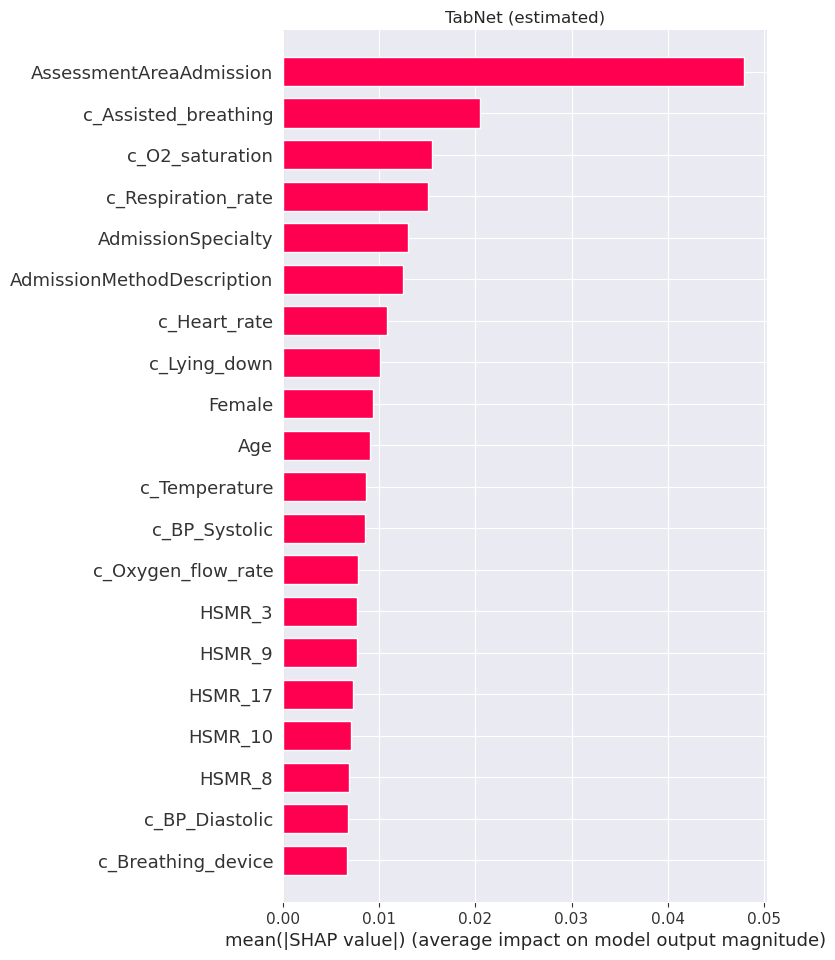

In [55]:
shap.summary_plot(
    shap_values[1],
    X_test_tn_shap,
    feature_names=X_test.columns,
    show=False,
    max_display=Notebook.SHAP_PLOTS_MAXDISPLAY,
    plot_type="bar",
    color=shap.plots.colors.red_rgb,
)
plt.title("TabNet (estimated)")

if Notebook.SAVE_IMAGES:
    plt.savefig(f"{Notebook.IMAGE_DIR}/shap_bar_tabnet.png", bbox_inches="tight")


In [56]:
if Notebook.SAVE_MODELS:
    with open(f"{Notebook.MODEL_DIR}/models.bin", "wb") as file:
        pickle.dump(Notebook.MODELS, file)

    with open(f"{Notebook.MODEL_DIR}/explainers.bin", "wb") as file:
        pickle.dump(Notebook.EXPLAINERS, file)


## Comparisons

### Scores

#### Pre-tuning scores

In [57]:
pd.concat(
    [results[0].assign(Model=key) for key, results in Notebook.EVAL_RESULTS.items()]
).set_index("Model")



Accuracy  Precision    Recall  F1 Score  \
Model                                                                      
Baseline (NEWS)                  0.979539   0.129032  0.350230  0.188586   
Logistic Regression (NEWS only)  0.866162   0.034182  0.686636  0.065122   
Logistic Regression              0.963021   0.109943  0.626728  0.187070   
Random Forest                    0.941997   0.085150  0.774194  0.153425   
XGBoost                          0.941622   0.087956  0.811060  0.158702   
LightGBM                         0.918283   0.068157  0.870968  0.126421   
Isolation Forest                 0.883557   0.039905  0.700461  0.075509   
TabNet                           0.975097   0.115538  0.400922  0.179381   

                                 F2 Score       AUC       AUC_CI  
Model                                                             
Baseline (NEWS)                  0.260810  0.837290  0.805-0.868  
Logistic Regression (NEWS only)  0.142529  0.837522  0.804-0.869  
Logistic Regression              0.323040  0.915763  0.891-0.938  
Random Forest                    0.295671  0.943437  0.926-0.959  
XGBoost                          0.306727  0.950320  0.936-0.964  
LightGBM                         0.259544  0.947450  0.930-0.963  
Isolation Forest                 0.162497  0.867229  0.840-0.892  
TabNet                           0.268353  0.859885  0.828-0.889

#### Post-tuning scores

In [58]:
pd.concat(
    [results[0].assign(Model=key) for key, results in Notebook.TUNED_RESULTS.items()]
).set_index("Model")



Accuracy  Precision    Recall  F1 Score  \
Model                                                                      
Logistic Regression (NEWS only)  0.534382   0.012498  0.866359  0.024641   
Logistic Regression              0.863753   0.041038  0.852535  0.078307   
Random Forest                    0.900294   0.056716  0.875576  0.106532   
XGBoost                          0.914842   0.065255  0.866359  0.121369   
LightGBM                         0.923070   0.070498  0.847926  0.130173   
Isolation Forest                 0.616381   0.015759  0.903226  0.030978   
TabNet                           0.811288   0.027620  0.783410  0.053358   

                                 F2 Score       AUC       AUC_CI  
Model                                                             
Logistic Regression (NEWS only)  0.059082  0.837522  0.804-0.869  
Logistic Regression              0.172061  0.915763  0.891-0.938  
Random Forest                    0.225225  0.943437  0.926-0.959  
XGBoost                          0.250734  0.950320  0.936-0.964  
LightGBM                         0.264520  0.947450  0.930-0.963  
Isolation Forest                 0.073657  0.867229  0.840-0.892  
TabNet                           0.121031  0.859885  0.828-0.889

### ROC

In [59]:
roc_dict, pr_dict = (
    {key: val[1] for key, val in Notebook.EVAL_RESULTS.items()},
    {key: val[2] for key, val in Notebook.EVAL_RESULTS.items()},
)



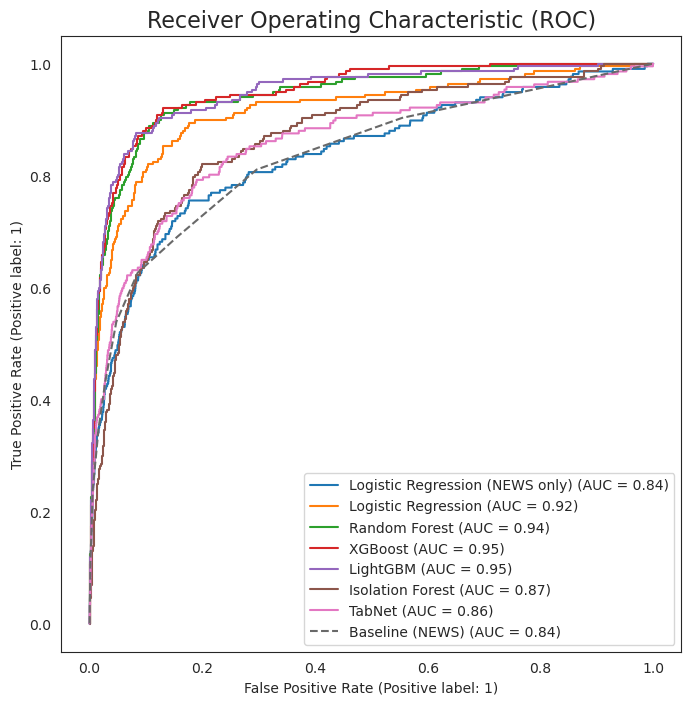

In [60]:
joint_plot(
    roc_dict,
    filename=f"{Notebook.IMAGE_DIR}/combined_roc_curve"
    if Notebook.SAVE_IMAGES
    else None,
    ax=None,
    title="Receiver Operating Characteristic (ROC)",
)


### Precision-Recall

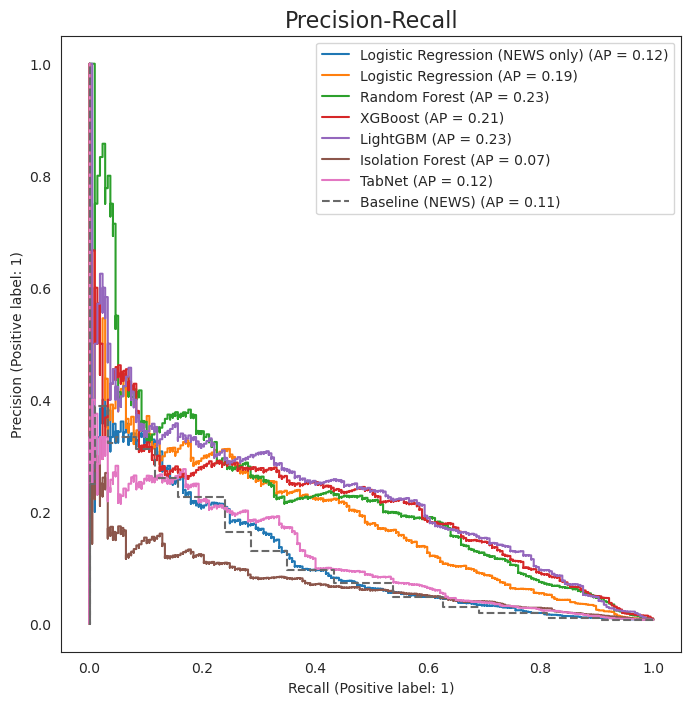

In [61]:
joint_plot(
    pr_dict,
    filename=f"{Notebook.IMAGE_DIR}/combined_pr_curve"
    if Notebook.SAVE_IMAGES
    else None,
    ax=None,
    title="Precision-Recall",
    legend_location="upper right",
)


### Side-by-side

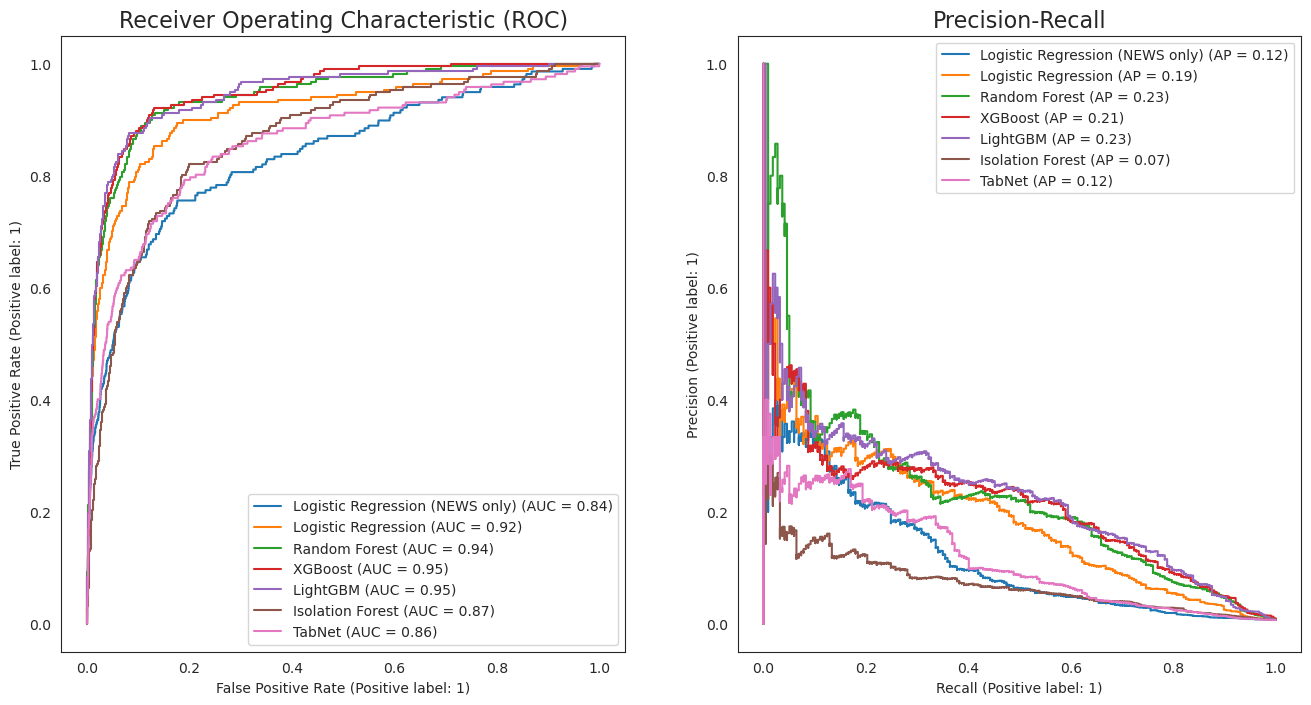

In [62]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
joint_plot(
    pr_dict,
    ax=ax[1],
    title="Precision-Recall",
    legend_location="upper right",
    plot_baseline=False,
)
joint_plot(
    roc_dict,
    ax=ax[0],
    title="Receiver Operating Characteristic (ROC)",
    plot_baseline=False,
)

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/combined_curves_no_baseline.png", bbox_inches="tight"
    )



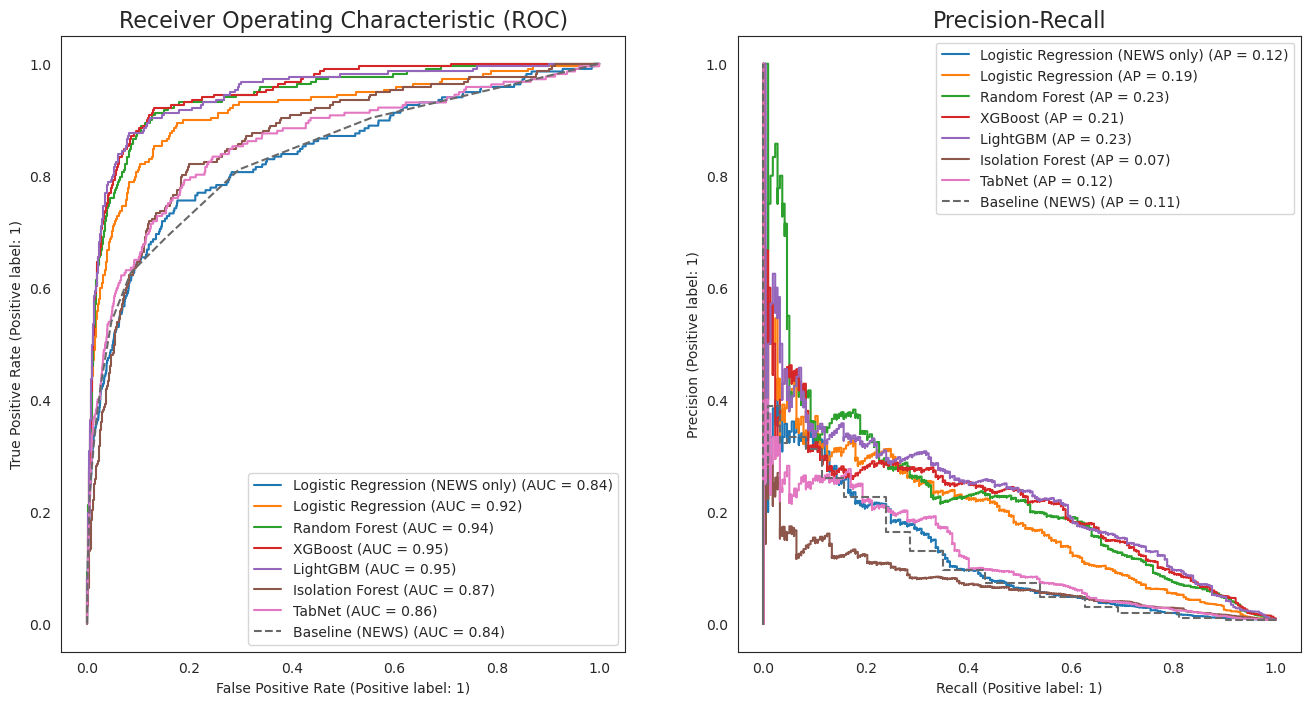

In [63]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
joint_plot(
    pr_dict, ax=ax[1], title="Precision-Recall", legend_location="upper right",
)
joint_plot(
    roc_dict, ax=ax[0], title="Receiver Operating Characteristic (ROC)",
)

if Notebook.SAVE_IMAGES:
    plt.savefig(f"{Notebook.IMAGE_DIR}/combined_curves.png", bbox_inches="tight")


### SHAP Explanations (Setup - skip to next section)

In [64]:
y_preds = pd.DataFrame(
    {
        key: model.predict(
            {
                "LightGBM": X_test,
                "Isolation Forest": X_test_if,
                "TabNet": X_test.to_numpy(),
                "XGBoost": X_test,
                "Random Forest": X_test,
                "Logistic Regression": X_test,
            }[key]
        )
        for key, model in Notebook.MODELS.items()
        if key != "Logistic Regression (NEWS only)"
    }
)

candidates = y_preds[y_preds.all(axis=1)].index

patient = candidates[0]
patient_data = X_test.iloc[patient].apply(
    lambda x: f"{x:.2f}" if type(x) == np.float64 else x
)
patient_data_if = X_test_if.iloc[patient].copy()
patient_data_if.update(X_test.iloc[patient])

explanations = {
    modelkey: shap_values[patient]
    for modelkey, (_, shap_values) in Notebook.EXPLAINERS.items()
    if not modelkey in ["TabNet", "Logistic Regression (NEWS only)"]
}
for _ in explanations.keys():
    if len(explanations[_].shape) > 1:
        explanations[_] = explanations[_][:, 1]

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")

    tabnet_explainer = Notebook.EXPLAINERS["TabNet"][0]
    explanations["TabNet"] = shap.Explanation(
        tabnet_explainer.shap_values(X_test.to_numpy()[patient])[1],
        data=patient_data.values,
        base_values=tabnet_explainer.expected_value[1],
        feature_names=patient_data.index,
    )



### SHAP Force Plots

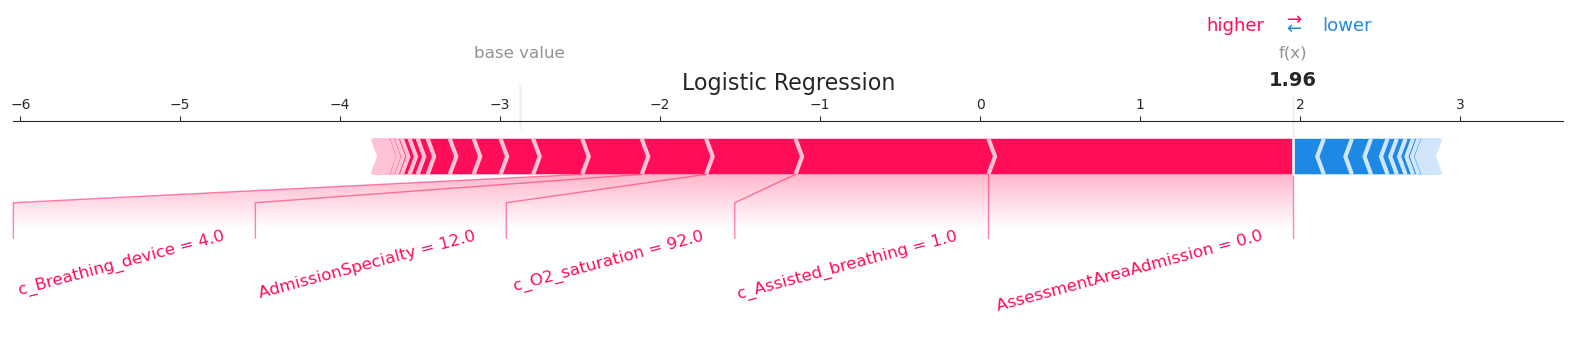

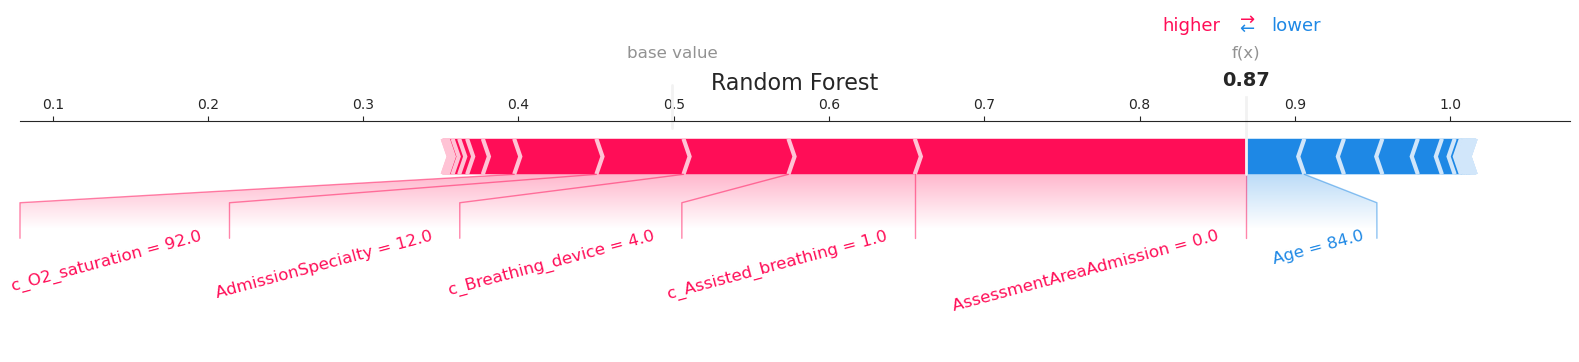

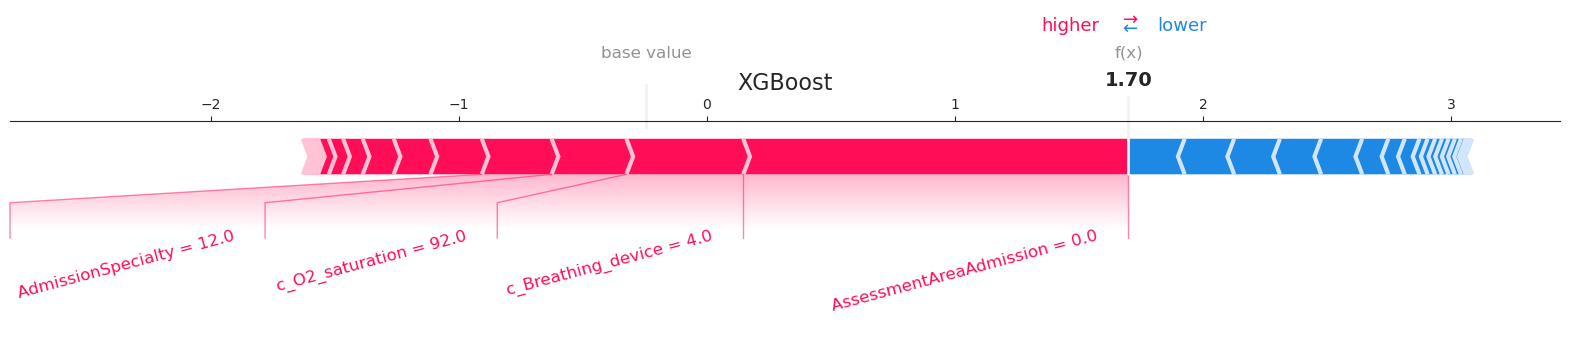

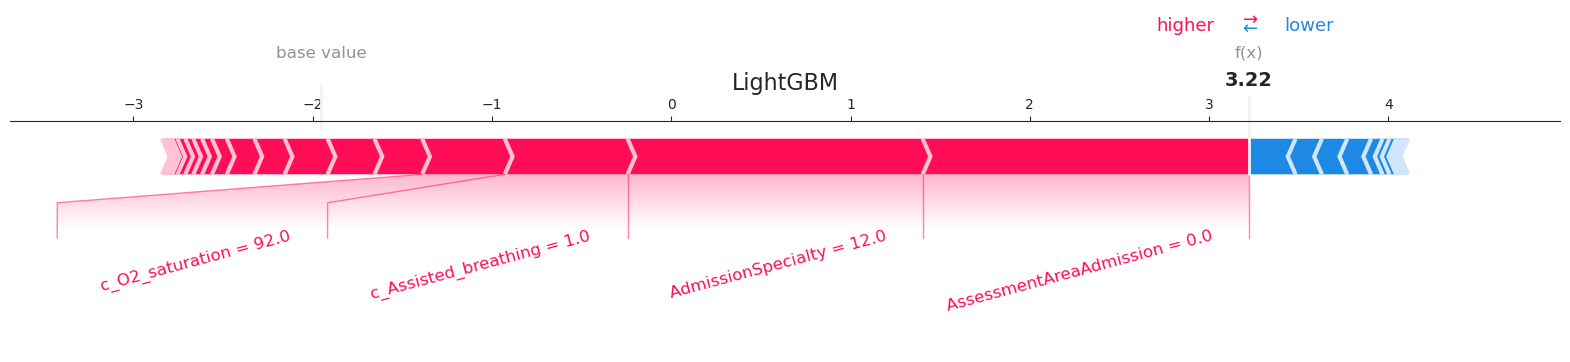

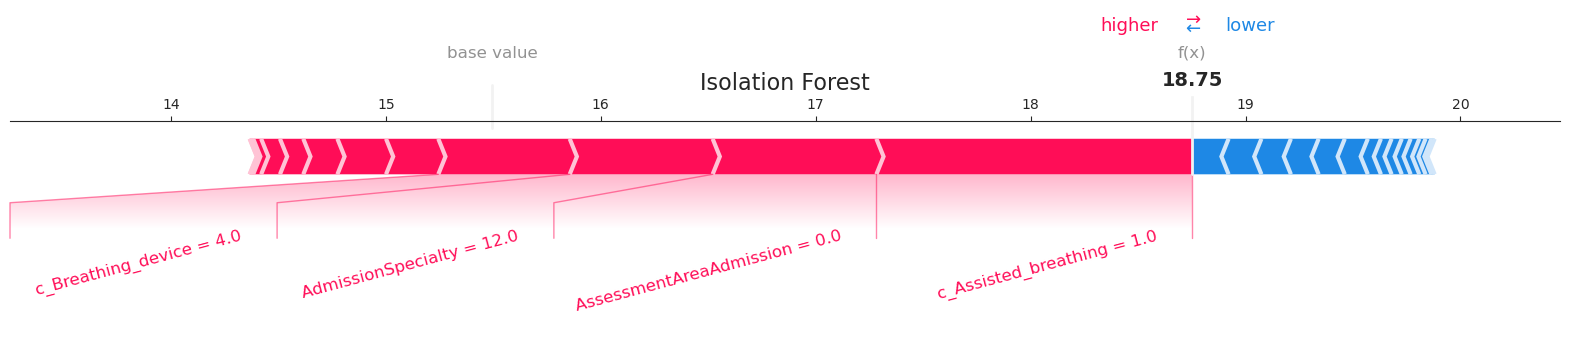

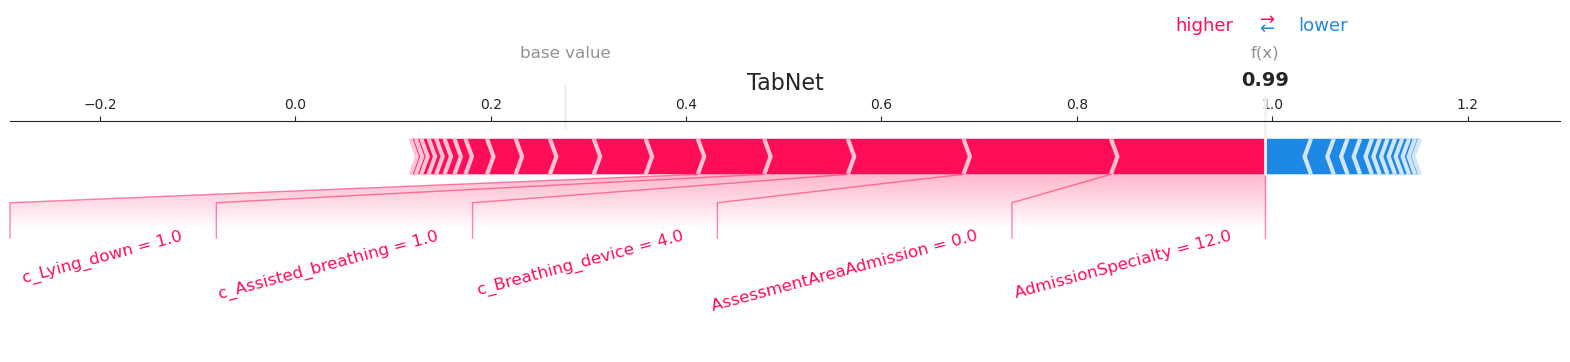

In [65]:
sns.set_style("white")
plt.rc("axes", titlesize=16)
for modelkey, explanation in explanations.items():
    patient_to_use = patient_data if modelkey != "Isolation Forest" else patient_data_if

    explanation = shap.Explanation(explanation)
    explanation.data = patient_to_use.values

    fig = shap.plots.force(
        explanation,
        feature_names=patient_to_use.index,
        matplotlib=True,
        contribution_threshold=0.08,
        show=False,
        text_rotation=15,
    )

    plt.title(modelkey)
    display(fig)

    if Notebook.SAVE_IMAGES:
        plt.savefig(
            f"{Notebook.IMAGE_DIR}/comaprison_force_plot_{modelkey.replace(' ','')}.png",
            bbox_inches="tight",
        )

    plt.clf()

sns.set_style("darkgrid")



### Mortality-only Results

In [66]:
pd.concat(
    [
        results[0].assign(Model=key)
        for key, results in Notebook.MORTALITY_RESULTS.items()
    ]
).set_index("Model")



Accuracy  Precision    Recall  F1 Score  \
Model                                                                      
Baseline (NEWS)                  0.982699   0.106961  0.700000  0.185567   
Logistic Regression (NEWS only)  0.532036   0.005784  0.966667  0.011499   
Logistic Regression              0.861094   0.017524  0.877778  0.034363   
Random Forest                    0.897197   0.022985  0.855556  0.044767   
XGBoost                          0.911932   0.027074  0.866667  0.052508   
LightGBM                         0.920536   0.030651  0.888889  0.059259   
Isolation Forest                 0.613346   0.006754  0.933333  0.013411   
TabNet                           0.809004   0.011373  0.777778  0.022418   

                                 F2 Score       AUC       AUC_CI  
Model                                                             
Baseline (NEWS)                  0.331928  0.952171  0.926-0.973  
Logistic Regression (NEWS only)  0.028243  0.931502  0.893-0.964  
Logistic Regression              0.081142  0.934184  0.904-0.960  
Random Forest                    0.103774  0.939345  0.908-0.965  
XGBoost                          0.120333  0.950444  0.925-0.970  
LightGBM                         0.134680  0.956651  0.933-0.974  
Isolation Forest                 0.032820  0.901910  0.860-0.937  
TabNet                           0.053722  0.872256  0.828-0.912

In [67]:
roc_dict, pr_dict = (
    {key: val[1] for key, val in Notebook.MORTALITY_RESULTS.items()},
    {key: val[2] for key, val in Notebook.MORTALITY_RESULTS.items()},
)

joint_plot(
    roc_dict,
    filename=f"{Notebook.IMAGE_DIR}/combined_roc_curve_mortality"
    if Notebook.SAVE_IMAGES
    else None,
    ax=None,
    title="Receiver Operating Characteristic (predicting mortality only)",
)

joint_plot(
    pr_dict,
    filename=f"{Notebook.IMAGE_DIR}/combined_pr_curve_mortality"
    if Notebook.SAVE_IMAGES
    else None,
    ax=None,
    title="Precision-Recall (predicting mortality only)",
    legend_location="upper right",
)

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
joint_plot(
    pr_dict, ax=ax[1], title="Precision-Recall", legend_location="upper right",
)
joint_plot(
    roc_dict, ax=ax[0], title="Receiver Operating Characteristic (ROC)",
)

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/combined_curves_mortality.png", bbox_inches="tight"
    )


### Critical care-only results

In [68]:
roc_dict, pr_dict = (
    {key: val[1] for key, val in Notebook.CRITICALCARE_RESULTS.items()},
    {key: val[2] for key, val in Notebook.CRITICALCARE_RESULTS.items()},
)

joint_plot(
    roc_dict,
    filename=f"{Notebook.IMAGE_DIR}/combined_roc_curve_criticalcare"
    if Notebook.SAVE_IMAGES
    else None,
    ax=None,
    title="Receiver Operating Characteristic (predicting critical care only)",
)

joint_plot(
    pr_dict,
    filename=f"{Notebook.IMAGE_DIR}/combined_pr_curve_criticalcare"
    if Notebook.SAVE_IMAGES
    else None,
    ax=None,
    title="Precision-Recall (predicting critical care only)",
    legend_location="upper right",
)

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
joint_plot(
    pr_dict, ax=ax[1], title="Precision-Recall", legend_location="upper right",
)
joint_plot(
    roc_dict, ax=ax[0], title="Receiver Operating Characteristic (ROC)",
)

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/combined_curves_criticalcare.png", bbox_inches="tight"
    )
